In [1]:
!pip install openmm
!pip install mdtraj
!pip install biopython
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 143.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, shutil
import numpy as np
import mdtraj as md

import torch,torchvision
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from Bio.PDB import MMCIFParser, PDBIO
from Bio.PDB import PDBParser, NeighborSearch

from sys import stdout
from tqdm import tqdm
from pathlib import Path

from openmm.app import *
from openmm import *
from openmm.unit import *

In [4]:
def plot_rmsd(steps, rmsd, sample_folder, filename):
    # Plot RMSD
    plt.figure(figsize=(10,5))
    plt.plot(steps, rmsd)

    plt.grid(True)
    plt.xlim(0, 5e4)
    plt.ylim(ymin=0)

    # Get the current axes and configure x-axis ticks
    ax = plt.gca()  # "Get Current Axes"
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))  # Always use scientific notation
    ax.xaxis.set_major_formatter(formatter)

    plt.xlabel("Simulation Step")
    plt.ylabel("RMSD (nm)")
    plt.savefig(f"{sample_folder}/rmsd-{filename[:-4]}.png")

In [5]:
def simulate(sample_folder, filename, M):
    step_per_frame = 250
    temp_pdb = f"{sample_folder}/temp-{filename}"
    output_pdb = f"{sample_folder}/o-{filename}"
    dcd = f"{sample_folder}/traj-{filename[:-4]}.dcd"

    forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
    # Create a Modeller object
    pdb = PDBFile(temp_pdb)
    modeller = app.Modeller(pdb.topology, pdb.positions)
    # Get positions (in nanometers by default)
    positions = pdb.positions

    # Extract x, y, z coordinates as a list of floats
    coords = [(pos.x, pos.y, pos.z) for pos in positions]

    # Find min and max for each dimension
    x_coords, y_coords, z_coords = zip(*coords)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    min_z, max_z = min(z_coords), max(z_coords)

    # Calculate extents in each direction
    extent_x = max_x - min_x + .5
    extent_y = max_y - min_y + .5
    extent_z = max_z - min_z + .5

    # Add hydrogens to the structure
    modeller.addHydrogens()

    # Add a water box (TIP3P) around the system
    modeller.addSolvent(forcefield, model='tip3p',
                        boxSize=Vec3(extent_x, extent_y, extent_z)*nanometers)

    # Save the solvated topology
    solvated_pdb = f"{sample_folder}/solvated-{filename}"
    PDBFile.writeFile(modeller.topology, modeller.positions, open(solvated_pdb, 'w+'))

    system = forcefield.createSystem(modeller.topology, constraints=HBonds)
    timestep = .004*picoseconds
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, timestep)

    simulation = Simulation(modeller.topology, system, integrator)
    simulation.context.setPositions(modeller.positions)
    simulation.minimizeEnergy()

    # Add RMSD reporter
    simulation.reporters.append(DCDReporter(dcd, step_per_frame))
    simulation.reporters.append(PDBReporter(output_pdb, step_per_frame))
    simulation.reporters.append(StateDataReporter(stdout, step_per_frame, step=True,
                                                  potentialEnergy=True, temperature=True))

    n_steps = step_per_frame*200//1
    simulation.step(n_steps)

    traj = md.load(dcd, top=solvated_pdb)
    # Select protein atoms and metal ion(s)
    protein_ion = traj.topology.select(f"protein or resname {M.upper()}")

    # RMSD for all non-water
    rmsd = md.rmsd(traj, traj[0], atom_indices=protein_ion)
    steps = np.arange(0, len(rmsd)) * step_per_frame

    # Clean up files
    os.remove(dcd)
    os.remove(temp_pdb)
    return steps,rmsd

In [6]:
def run_openmm(M, num_ions):
    samples_dir = '/content/drive/MyDrive/Samuel/Samples'
    samples_dir += f"-{M}"

    samples_path = Path(samples_dir)  # Ensure it's a Path object
    all_sample_folders = [folder for folder in samples_path.iterdir() if folder.is_dir()]
    total_samples,m = len(all_sample_folders),0

    for i, sample_folder in enumerate(tqdm(all_sample_folders,
                                           desc="Processing sample folders",
                                           total=total_samples)):
        if i == 30: break

        sample_id = sample_folder.name
        for filename in os.listdir(sample_folder):
            if filename.endswith(f"{num_ions}.pdb"):
                #if filename[0] == 'o':
                #    print(f"\nAlready processed '{sample_id}'")
                #    continue
                if filename[0] not in ('o','t','s'):
                    print(f'\n{sample_id}')

                    # Preprocess PDB to rename LIG to the correct ion
                    input_pdb = f"{sample_folder}/{filename}"
                    temp_pdb = f"{sample_folder}/temp-{filename}"
                    with open(input_pdb, 'r') as f_in, open(temp_pdb, 'w') as f_out:
                        for line in f_in:
                            if line.startswith('HETATM') and 'LIG' in line[17:20]:
                                # Replace LIG with the correct ion name (columns 17-20)
                                line = line[:17] + f"{M.upper():<3}" + line[20:]
                                # Ensure atom name matches (columns 12-16, often Zn, Ca, Mg)
                                line = line[:12] + f"{M.upper():>4}" + line[16:]
                            f_out.write(line)

                    # Run the processing function with error handling
                    try:
                        steps,rmsd = simulate(sample_folder, filename, M)
                        plot_rmsd(steps, rmsd, sample_folder, filename)
                        os.remove(f"{sample_folder}/solvated-{filename}")
                    except Exception as e:
                        print(f"\n[ERROR] Failed to process sample '{sample_id}': {e}")
                        continue  # Move on to the next sample even if there's an error

In [ ]:
run_openmm('Ca',1)

Processing sample folders:   0%|          | 0/6196 [00:00<?, ?it/s]


6197
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-104398.89822117935,195.43901102698752
500,-100085.59053350317,258.0945434704086
750,-98032.47802856896,287.86712735409094
1000,-97807.84604405717,298.23010443117954
1250,-97885.421258597,308.52413687028985
1500,-98059.8092621391,303.2984597229427
1750,-97874.15213392294,303.21033232292916
2000,-98334.55917790277,298.297468837531
2250,-98295.07690258873,303.92770845754325
2500,-98438.08908275487,301.4013701749682
2750,-98554.93193023077,308.718752347274
3000,-98674.63263326473,298.7471312534093
3250,-98609.04394204816,300.722868056983
3500,-99202.87775600997,298.253047399194
3750,-99188.29899183831,304.9823167025926
4000,-98880.89529441796,303.0758633148645
4250,-99115.48857483234,304.36959053862944
4500,-99158.84494292462,304.1536271777984
4750,-99416.93121105808,294.3798488469732
5000,-99413.11031349962,302.9522569292192
5250,-99639.8035624789,298.80308560966046
5500,-100002.879817829,299.0190878689203
5750,-99510.25097

Processing sample folders:   0%|          | 1/6196 [09:22<967:45:06, 562.37s/it]


6200
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-129411.48360820638,189.19509623832792
500,-123073.28836061561,258.65919451861384
750,-120512.91558451075,289.4830696436618
1000,-119828.81569858374,299.54689650465104
1250,-119737.18090544482,302.58581478924765
1500,-119414.00406467007,297.7751051881409
1750,-119251.8568581966,302.5798209225022
2000,-119244.9702376299,303.8037559263704
2250,-119424.13949989082,298.7395491538784
2500,-119830.47980297238,306.8825496884669
2750,-119664.58390244943,302.7995782347612
3000,-120559.07523876902,300.4121109720605
3250,-121391.47996995207,301.9356217748674
3500,-121013.81306787442,293.12942866852416
3750,-121325.78471935003,298.13727467342835
4000,-120782.12058501532,296.56480429724553
4250,-121542.05570987893,297.8676374730395
4500,-121524.62837295086,297.8744424069282
4750,-121751.27560107542,297.076176510235
5000,-121714.26931905588,302.27859124661944
5250,-121524.64402073176,299.2864612155785
5500,-121609.26025982389,299.55973

Processing sample folders:   0%|          | 2/6196 [21:19<1124:37:58, 653.65s/it]


6201
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-54006.632821046805,191.06291941642988
500,-51641.48879506688,261.4911832803662
750,-50768.0305492233,281.01739061558106
1000,-50713.16591714928,292.1420516080355
1250,-50338.09267700512,290.7046860622621
1500,-50549.92788180059,299.88267054033895
1750,-50308.89899864049,289.34658852130514
2000,-50706.4696239782,294.33865227386667
2250,-50765.1949128618,303.1393214410039
2500,-50391.13609919535,302.7953728556617
2750,-50696.110880382344,302.62801961116475
3000,-50593.60269433709,298.11021686583945
3250,-50587.0435350084,299.4331900642276
3500,-50614.76359847087,302.40910849317595
3750,-50810.000147153434,309.4880838469494
4000,-50284.45883346612,310.3935189514476
4250,-50598.45116707851,302.1586148852726
4500,-50678.345267439734,298.59933002619243
4750,-50712.57823030047,297.3456633257327
5000,-50644.0074644984,301.4320351100258
5250,-50638.831230306496,301.01358120740827
5500,-50783.358257518456,304.2557923778387
5750,-5

Processing sample folders:   0%|          | 3/6196 [29:08<978:44:46, 568.95s/it] 


6203
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-19808.206836802226,189.4252467420088
500,-18891.33601142955,270.16331786907676
750,-18681.886861388306,297.23712440112615
1000,-18521.91224622928,299.84763051396817
1250,-18508.54056061306,302.11098955413786
1500,-18497.453942381173,299.98117340731324
1750,-18528.38333950049,297.93875998689117
2000,-18672.746814511785,291.007671842052
2250,-18464.99989303603,311.51258727850416
2500,-18849.833767520046,315.7639867562061
2750,-18759.773740514098,299.47216072439176
3000,-18641.198957477805,298.83163306731456
3250,-18778.709739831625,301.88973560891174
3500,-18843.26700720689,310.6833586713985
3750,-18574.36713666708,298.7795350893798
4000,-18705.62902930345,307.27743150681357
4250,-18663.013693556528,306.24288532770527
4500,-18771.18980420278,297.19958487834043
4750,-18728.10664514457,301.8207230942047
5000,-18658.133204540343,300.1518954000403
5250,-18729.349309530233,309.32919950044266
5500,-18577.315766700398,308.4972119

Processing sample folders:   0%|          | 4/6196 [36:01<872:58:49, 507.55s/it]


6202
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-332981.29352677363,192.32572515930732
500,-318184.4127808512,258.059217185115
750,-312036.7758608045,282.9952429793604
1000,-309190.7016655322,292.8877110224506
1250,-309434.47204685234,298.5364709076007
1500,-308541.3444260839,297.7762928869061
1750,-309702.7492211612,298.6776807728226
2000,-309444.760025314,299.2091079572555
2250,-309892.64254359575,303.39241704818807
2500,-310665.8491339582,302.476363590893
2750,-310598.5623194541,300.43391467661576
3000,-310218.98065008776,301.5704925420659
3250,-311025.76254662545,303.5313989057901
3500,-311333.0141659395,300.7706545453389
3750,-311466.47620224056,298.9580966711417
4000,-312487.8161142201,303.0095255670927
4250,-312103.13521747873,299.81577331143023
4500,-312859.6675656168,302.5082478571223
4750,-311670.5597949526,299.616077567155
5000,-311754.49710137106,302.2877162739661
5250,-312728.2066615992,301.5108256174337
5500,-311931.82100866345,300.9879982166233
5750,-312

Processing sample folders:   0%|          | 5/6196 [1:00:57<1486:01:18, 864.11s/it]


6204
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-40458.88797375707,184.65943169160516
500,-38709.78625714773,261.28998934684097
750,-37618.23971361978,283.353787589793
1000,-37442.71388905904,295.37507914121477
1250,-37613.1405833904,298.4542477307166
1500,-37644.50682994242,296.7872301912344
1750,-37569.13347236318,301.9676479057715
2000,-37868.97560305183,288.5242686783
2250,-37904.71932484437,298.43522362893907
2500,-37700.60457047454,299.028128512496
2750,-37663.00316096837,298.58265083746403
3000,-37711.52424829898,301.25876883236486
3250,-38066.83551453732,300.2430449342129
3500,-37630.58919072517,302.33720126877085
3750,-37927.26756150776,304.5670098898987
4000,-38126.22026467643,299.70116920967826
4250,-38082.301259936954,303.7076752068379
4500,-37776.09551806571,298.2686582457371
4750,-38193.609586442784,298.15958807428694
5000,-38508.120421541724,299.5445296753949
5250,-38204.33393202221,304.0421080772384
5500,-38020.013966699225,304.7421590593791
5750,-38102

Processing sample folders:   0%|          | 6/6196 [1:08:48<1256:00:58, 730.48s/it]


6206
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-96396.52175921877,191.19931019777928
500,-92760.5843065698,252.7143059805601
750,-91227.89215648531,280.1360991141344
1000,-90304.69798087854,293.09073605004744
1250,-89994.9922768214,288.43742233026796
1500,-89752.40741644277,301.6501712115313
1750,-89514.64588852851,299.449647452216
2000,-89556.00187315494,293.3846302469204
2250,-89700.93428877203,302.9593714078874
2500,-89312.49631365637,303.8530948050748
2750,-89352.20574959472,297.4304406714678
3000,-89494.01402393269,304.08630351060197
3250,-90015.85351740767,305.1607987173004
3500,-89901.26765477164,304.4353575382688
3750,-89626.60432085762,299.1025317519885
4000,-89695.5038776045,300.2973089567647
4250,-89699.34634915434,293.737462105019
4500,-89351.77085563562,305.7491560397679
4750,-89760.7501859367,306.64818122507427
5000,-89772.55329805297,296.90377011203077
5250,-89618.02779269562,302.0716056969091
5500,-89671.73640998837,297.21294900150104
5750,-90403.43747

Processing sample folders:   0%|          | 7/6196 [1:17:32<1139:24:45, 662.77s/it]


6205
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-192808.08890181273,189.27398598137702
500,-184762.10487810377,257.5068486616002
750,-181599.37718880497,284.17391937711596
1000,-181051.16041054498,295.20404331514675
1250,-179966.28021324667,300.4043670009018
1500,-178934.14618115601,304.38151742360657
1750,-179455.41103451542,307.75241360908404
2000,-179807.64623491626,302.98130746866366
2250,-180433.16857891035,302.18686231204106
2500,-180755.41627235888,299.6905089409851
2750,-180264.13242654124,297.6247345696059
3000,-180932.785545826,300.54880846070165
3250,-180668.0864767333,300.3985878592621
3500,-181274.20086569438,302.6610602076296
3750,-181092.3547725219,302.4692554018945
4000,-181284.62957490075,299.7230849116565
4250,-181062.47304381616,299.52529778847196
4500,-181546.39730328228,301.49466697023036
4750,-181863.30112621645,300.75571400602865
5000,-181373.1587283335,301.9326649498244
5250,-181567.046012243,304.3774573120256
5500,-182097.67310611834,302.438837

Processing sample folders:   0%|          | 8/6196 [1:31:30<1235:22:03, 718.70s/it]


6208
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-295953.6001395547,193.28735555773136
500,-282022.81654495234,259.4323597977985
750,-275874.326169833,285.6793429251025
1000,-274929.3964779769,292.89206871287695
1250,-274345.274306559,297.8337006473597
1500,-273680.60341234575,295.0590572478106
1750,-273906.94840446016,298.54984426523544
2000,-274672.8219712739,299.6058218748689
2250,-274242.6505777957,299.0426396749181
2500,-273566.5807814713,300.9611249416491
2750,-274961.70522146544,303.09400488298263
3000,-275805.03316902264,297.9149478922319
3250,-275224.7898204338,300.1835098725936
3500,-275967.861486446,300.5390389204851
3750,-276096.1395030079,298.0149928805691
4000,-276629.818922589,300.7720468694745
4250,-276057.243666496,298.798581308997
4500,-276469.94096933404,302.56138754084213
4750,-276374.54875472287,303.86432488189723
5000,-276428.10409937747,300.8840597079112
5250,-275822.8161243218,302.1985196781132
5500,-275576.1301835751,300.5248608921565
5750,-2762

Processing sample folders:   0%|          | 9/6196 [1:55:03<1608:04:22, 935.68s/it]


6207
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-147885.63015076448,191.6832417135961
500,-141061.6538118135,260.7331663746652
750,-138322.84296180826,282.34804734816925
1000,-137314.62924903998,291.1068235245299
1250,-137667.05859844782,296.713163745489
1500,-137727.13025840913,294.18103157182054
1750,-137356.91860419145,297.3639144733032
2000,-137814.5545857552,299.5687518185281
2250,-137614.36606955776,298.5873761123643
2500,-137500.75782555155,299.63191829662827
2750,-138562.76630952663,302.2274253712049
3000,-138545.40659101,302.6500059839323
3250,-137741.63239335126,304.4038389834169
3500,-137404.26473567146,298.52530804295446
3750,-138090.4552692984,304.44983309696573
4000,-138656.47618070172,304.4788484944252
4250,-138665.7694081441,301.2249869614813
4500,-139104.66692828544,304.8827402826907
4750,-138831.39582903072,296.4644558474769
5000,-138967.93562910534,297.29937271898984
5250,-138681.3161213501,300.07485495702895
5500,-138776.30519006576,300.537482637781

Processing sample folders:   0%|          | 10/6196 [1:57:43<1196:25:31, 696.27s/it]


[ERROR] Failed to process sample '6207': Particle coordinate is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

6209
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-82095.70074085356,190.08832798684256
500,-78221.45596770734,257.4201106746993
750,-76942.81127071787,284.79836812089206
1000,-76202.16076835591,298.5733988006536
1250,-76365.88689812826,294.49493554649536
1500,-76989.79287990437,298.7308688083012
1750,-76552.91477070258,301.6363605249156
2000,-76937.46257982738,299.14103064635947
2250,-76906.10631138393,294.89569204346094
2500,-77089.06045047229,304.1708603869715
2750,-76905.83984973257,300.87947267007416
3000,-76689.71841976333,303.51181082408647
3250,-77192.11870043934,305.5791922912305
3500,-77340.47061163533,305.5375221574781
3750,-77203.37051936294,298.8877831524934
4000,-77637.1858418159,295.92512168428567
4250,-77848.3606562618,303.9017808104247
4500,-77915.61152989903,305.09455562770455
4750,-77411.0

Processing sample folders:   0%|          | 11/6196 [2:06:34<1109:17:06, 645.66s/it]


6211
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-37246.36121454116,187.31173437079858
500,-35605.58222699406,267.00021913228966
750,-34943.62268393072,283.98457381465084
1000,-34706.44986091704,286.0284261260206
1250,-34593.33295272109,292.32851030470874
1500,-34512.81031427707,296.57471912063863
1750,-34634.542401616054,303.6262605731104
2000,-34839.453141742975,312.49322574767444
2250,-34886.64455348354,299.551007497339
2500,-35013.6434766717,301.1218049863169
2750,-34901.71783437403,304.55483151333095
3000,-34755.17322149839,294.68342560758254
3250,-35167.28379231949,300.01930340912844
3500,-34752.768952824284,295.8462321852685
3750,-35074.1360100615,299.8299770295684
4000,-35212.014513044036,303.556158044272
4250,-35145.71993160181,296.1254431091115
4500,-34925.97873246644,301.4220822686711
4750,-35155.07122343116,295.56207458184747
5000,-35361.518427503404,300.57659446381825
5250,-34934.667700908176,287.60617158853523
5500,-35337.60602993427,300.97851301443455
575

Processing sample folders:   0%|          | 12/6196 [2:13:57<1002:55:04, 583.85s/it]


6212
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-115085.36789161705,190.399676161111
500,-110259.67272573539,255.8048098347301
750,-108432.91831232121,289.2273078121081
1000,-107107.34268605719,291.968618277368
1250,-107186.62494904813,296.668993069944
1500,-107043.44487522893,297.35795057536217
1750,-106877.76416862987,296.8248921500996
2000,-107329.12788902014,299.3154869034985
2250,-107000.4032271727,295.2640518252807
2500,-107646.85371390774,303.46168612986423
2750,-107606.49729344591,300.7817731743225
3000,-107933.34439280747,302.3623641753124
3250,-107623.708502582,302.9157677644487
3500,-107672.82897812937,303.70690191752135
3750,-107942.51706925136,300.43414001545085
4000,-107949.67017785415,300.2040439150386
4250,-108074.38761308733,299.96713499325955
4500,-107811.49242788501,295.8567904164087
4750,-107933.16042109138,303.2353669716882
5000,-107342.38324946395,305.1097112480607
5250,-107388.4425577977,306.98039314145535
5500,-107936.55576455036,297.39379707211

Processing sample folders:   0%|          | 13/6196 [2:24:09<1017:34:48, 592.48s/it]


6213
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-170826.0194988521,191.51445687908284
500,-162345.80373741055,259.63144002423195
750,-159050.7422884593,283.89327521308854
1000,-157692.70898923377,294.6946314897696
1250,-157012.1927799346,300.3621195763255
1500,-156993.30760020562,303.43035655659236
1750,-157397.3638513959,304.93511852653324
2000,-157386.00806068632,304.9360853691425
2250,-157860.00482699552,301.8705160800738
2500,-158204.2364556066,301.9722663845338
2750,-158004.97773809073,300.9510955825416
3000,-158661.11589891347,305.4359805644147
3250,-158096.23558952115,298.8358230396749
3500,-158800.95683152755,300.2872152237848
3750,-158655.27584563615,303.10436575272496
4000,-158540.16567228767,304.5848266214343
4250,-158575.76299141813,300.7507807335054
4500,-157994.18027678315,303.4281426773124
4750,-159323.51423320005,304.135975631927
5000,-158978.95370062737,297.5063430625376
5250,-159320.59650789498,299.19215055938025
5500,-159990.38897180572,299.742327217

Processing sample folders:   0%|          | 14/6196 [2:37:29<1125:21:08, 655.33s/it]


6214
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-111663.34486155346,190.97352103291405
500,-107003.26872093762,259.494149851518
750,-104928.70970992542,288.20739320913054
1000,-104311.92424963438,298.1359334927702
1250,-104162.77855318449,297.0745907097499
1500,-104399.76311921443,296.8815350720816
1750,-104479.5468258557,304.25200515992753
2000,-104297.36323498507,298.3782692782558
2250,-104188.69686841425,301.44786687692175
2500,-104881.75484623425,304.35009183010317
2750,-104394.18495561992,301.0547290392293
3000,-104570.2636858643,299.3213443746755
3250,-104268.89580294189,300.5496861916959
3500,-104804.5812659979,304.44769398189453
3750,-104760.50606927427,304.15146525345017
4000,-104696.56735489522,304.7222505696053
4250,-104500.65046492199,301.27762697045245
4500,-104354.19124348485,303.67497834929986
4750,-104616.62580893215,296.88336071539146
5000,-104970.878363941,305.3419321350181
5250,-105249.51598951548,306.31682468828865
5500,-105078.33433556299,302.25840

Processing sample folders:   0%|          | 15/6196 [2:47:52<1108:25:29, 645.58s/it]


6215
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-164799.3808327223,189.86974221317845
500,-156761.9270528396,258.6220537084386
750,-153891.72371936127,282.2872359661302
1000,-152495.6662909756,294.6123604290248
1250,-152036.39195734146,296.2897384893694
1500,-152342.63299456966,300.4472980490313
1750,-152394.56142720114,304.0846230934154
2000,-151659.91599386992,298.8880122715536
2250,-151368.67911945024,298.55076663277544
2500,-152685.23579390065,303.3206946994293
2750,-152855.73451119516,304.2031547345474
3000,-153366.33620135204,298.2701707785858
3250,-153087.99961392174,301.09883368411283
3500,-152978.73008995343,302.6704406688498
3750,-152907.21254973178,299.08893102885247
4000,-152984.61912487916,297.6112491187626
4250,-153476.47762626174,299.288908629515
4500,-153340.33642993192,302.32764775410556
4750,-152664.30489629038,299.61722966032426
5000,-152906.02458241946,297.3713357867394
5250,-153395.63587861374,302.65198576076614
5500,-153347.55875376015,301.8270940

Processing sample folders:   0%|          | 16/6196 [3:00:44<1173:22:00, 683.51s/it]


6216
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-68873.7736703987,191.91842420430297
500,-65594.22097846013,261.43204192381296
750,-64471.28202515785,289.780678173536
1000,-64268.90014682113,302.9404354424158
1250,-63851.806411359,300.7941919143507
1500,-63970.16940916135,303.31887933721566
1750,-63802.380214412704,295.7374918718233
2000,-63685.94819700379,296.0998755178633
2250,-64212.44959736212,301.93919926656196
2500,-64183.99668837347,298.4627452672156
2750,-64132.96014517032,300.8838811799826
3000,-64468.926362434715,301.9520228090631
3250,-64084.48483137611,292.9008277880324
3500,-64198.85447714762,290.207215789884
3750,-64516.3077431158,312.26533426328376
4000,-64657.849270475956,310.9627166093183
4250,-64509.91890986295,298.8556644600503
4500,-64713.921877048306,304.44310264978617
4750,-64620.032959576674,300.3828258687366
5000,-64555.54792704013,291.2787121092261
5250,-64915.42570080035,296.52021910691036
5500,-64755.08336733269,300.4475904079837
5750,-64412.

Processing sample folders:   0%|          | 17/6196 [3:09:15<1084:04:46, 631.60s/it]


6218
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-47584.14513493793,193.33899767297675
500,-45796.36031396619,258.40044359987456
750,-45103.751277781004,281.3944400084519
1000,-44731.90709227233,290.6389191719561
1250,-44513.0386848439,293.0708562227673
1500,-44677.31266887849,293.73842923611465
1750,-44407.685728695884,306.57874012691383
2000,-44639.29217022311,304.3522820860276
2250,-44777.408523125116,295.7547158221994
2500,-44931.667705898886,300.1761573573253
2750,-44826.44821254921,304.38498309487613
3000,-44670.887389934396,299.97291189012066
3250,-44429.992430383485,298.2745951492584
3500,-44784.40034339656,305.36137027893807
3750,-45078.07624500462,304.2185726084992
4000,-45001.28940554602,298.0356361263898
4250,-45562.71815409541,305.5978674773768
4500,-45132.89090046559,291.36330730204315
4750,-45296.72466956392,291.2706496177426
5000,-45230.07694936999,289.2724521483347
5250,-45426.53404789808,288.2524363168307
5500,-45267.95740930627,292.3798198124739
5750,

Processing sample folders:   0%|          | 18/6196 [3:17:07<1001:43:29, 583.72s/it]


6220
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-62621.61201647476,194.65339908482645
500,-60153.276679808965,258.1936931189399
750,-59782.580699716134,289.8857229036516
1000,-58762.78737062691,292.6245372287861
1250,-58355.78558254707,304.0407939247021
1500,-58587.8221107894,309.80899019700115
1750,-58417.88984160052,304.12965045001414
2000,-58395.68810768575,299.52959869239993
2250,-58366.483208272475,300.8108058931769
2500,-58688.59380037955,307.32522008769695
2750,-58657.42926628575,299.9910865298376
3000,-59041.783070964426,301.5262226397017
3250,-59064.805188292856,305.95132970904706
3500,-59164.88246335992,291.85090169274406
3750,-58977.11498699922,291.6997145462924
4000,-59460.39186157198,296.04200111503707
4250,-59616.03572588992,302.9455094362933
4500,-59409.654472549475,299.536394002818
4750,-59638.11351275775,298.3120810241184
5000,-59337.72184556045,299.4649504217366
5250,-59233.027983455606,301.5954229418975
5500,-59159.35023368918,303.4824501659853
5750,

Processing sample folders:   0%|          | 19/6196 [3:25:09<948:51:54, 553.01s/it] 


6219
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-290054.01784582104,191.49563488020058
500,-276729.961389543,256.19964307868884
750,-272198.9633263992,283.8261222966623
1000,-270329.62233520334,294.2444801658646
1250,-268894.443333837,298.44281811824715
1500,-268652.12915681873,300.2549588361453
1750,-267906.40930537984,301.6608454161961
2000,-268914.76943830104,299.9534999517725
2250,-268882.86856980535,303.21427056710326
2500,-269155.8553359646,298.7610281027012
2750,-269215.2360621292,302.55855904708153
3000,-269587.7223478002,302.62724416323005
3250,-270213.7558544875,301.86673035183
3500,-270204.3611274041,304.9283399592774
3750,-269938.15074329305,300.9270449233034
4000,-270720.8567583767,306.40217811171556
4250,-270197.41781753313,304.0643618750007
4500,-269846.3218643437,301.35089095357154
4750,-271257.7763980192,301.2432488012316
5000,-271465.8015302013,300.03266480912094
5250,-271064.9540334417,302.8559902800041
5500,-271202.9862819441,296.4642848064892
5750,

Processing sample folders:   0%|          | 20/6196 [3:47:22<1350:28:23, 787.19s/it]


6221
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-9596.92139273074,197.08215214092982
500,-9397.92811289354,262.1068712999882
750,-9285.17647148848,268.71728036428436
1000,-9317.71430324377,288.9645029390119
1250,-9386.75820234968,305.3910490435773
1500,-9471.77542586916,327.5757431562697
1750,-9565.94180136628,307.45850074707477
2000,-9525.528386408716,300.30511908134275
2250,-9513.805420862045,288.4948370928949
2500,-9522.52292185724,277.0462648132298
2750,-9529.873568236591,312.76370296041074
3000,-9557.075508604701,316.996037780804
3250,-9558.560821583542,305.9708671110535
3500,-9533.675446831083,304.8090985637425
3750,-9616.764710757696,302.68301797673365
4000,-9553.167769821848,294.7737382336858
4250,-9494.020707832264,306.79357362132725
4500,-9606.770030218559,309.9093620961452
4750,-9668.357266785504,299.84624722923036
5000,-9573.387739296357,289.64448665614026
5250,-9731.83034267587,294.77368934545376
5500,-9628.366689761355,289.90741786861713
5750,-9563.771712

Processing sample folders:   0%|          | 21/6196 [3:53:42<1140:35:39, 664.96s/it]


6222
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-141385.8280717131,192.56798552651065
500,-135096.75123105018,264.88935973843843
750,-132276.42127214393,288.1677601657993
1000,-131190.33534986264,294.89526925565787
1250,-130863.72739785771,300.85879433855564
1500,-130860.05116646845,303.3524487619808
1750,-131240.1580143707,295.6849991578578
2000,-131406.2598221376,301.2783576138885
2250,-131056.2267248768,305.3384710355652
2500,-131441.43749330705,301.56310337483967
2750,-130913.12750106536,299.05909394299874
3000,-131354.0446588739,295.59649439629555
3250,-132077.60642563243,304.66689482789985
3500,-132267.9427307884,302.2418368629187
3750,-131939.5761216773,297.27227721718555
4000,-132414.335635244,300.8842412473067
4250,-132298.48389386997,305.24863621978227
4500,-132765.33041176613,299.33642964403396
4750,-132232.3506339167,295.63459391215827
5000,-132582.629255365,306.8873618227855
5250,-132756.8244931429,307.1364109732295
5500,-132114.34679230978,301.10760332228

<ipython-input-4-6034f5470a66>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))
Processing sample folders:   0%|          | 22/6196 [4:06:00<1177:57:41, 686.86s/it]


6223
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-41784.45265878706,185.46000074950047
500,-39733.24375194911,260.0530929274904
750,-39022.115344665406,286.37655663849347
1000,-38587.57377413179,292.718104587054
1250,-38754.36782156681,291.1361004722619
1500,-38887.44924610152,305.9945653683671
1750,-38415.297425064215,307.1784592179249
2000,-38768.61619986647,305.62428585281947
2250,-38547.90623000839,311.68940621327107
2500,-38867.97611615917,305.208904395946
2750,-38750.3095942464,306.9798915725061
3000,-39077.57267400387,303.56279875939265
3250,-39137.72544627907,306.61598057722864
3500,-38816.98327274896,297.8910304077984
3750,-39081.08181430491,306.4391852958016
4000,-38785.52598244329,308.4025565534967
4250,-38912.337097058946,301.3789468285342
4500,-38898.41547676845,305.2906269368878
4750,-38775.68211151888,306.76309749238044
5000,-38808.70693132633,296.99398753521814
5250,-38682.74398136649,299.32307439840423
5500,-38548.81182193704,304.329907929646
5750,-3887

Processing sample folders:   0%|          | 23/6196 [4:13:43<1062:35:10, 619.68s/it]


6224
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-41350.1860747103,188.7454990888255
500,-39585.4196629253,258.55214332708783
750,-38903.828061804335,293.5624671243815
1000,-38858.32305004165,295.5276842128406
1250,-38340.82822461037,301.5395368535449
1500,-38765.546706208006,306.5517794870105
1750,-38812.63746450612,296.7194170472701
2000,-38714.7160028346,302.1468099009006
2250,-38772.59053005419,306.1378979462491
2500,-38811.91654172275,302.40234264370787
2750,-38916.058586004154,296.0128185798703
3000,-39192.93382621936,308.0769914850584
3250,-39500.92042133202,299.47547477613347
3500,-39552.52761232984,296.2222023829041
3750,-39811.02263686512,289.0861714470413
4000,-39682.77758455579,302.6487762643994
4250,-39425.890347793014,311.1984023416062
4500,-39294.6179591279,300.8426421718998
4750,-39573.90404697106,300.75195119247576
5000,-39699.36449927102,303.26559525615903
5250,-39387.811476642644,309.5704134181949
5500,-39432.34550988357,299.29499163979835
5750,-39453

Processing sample folders:   0%|          | 24/6196 [4:21:27<982:26:24, 573.04s/it] 


6226
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-398572.6996032716,191.69742606924444
500,-380874.8893274531,259.4550742840653
750,-374613.9447697707,283.424718676651
1000,-371898.35890464275,292.4613688049022
1250,-370765.5666594815,298.0750276686502
1500,-370008.12353341986,299.65006567318505
1750,-370183.3531083128,299.45391223873656
2000,-370820.02923825185,299.9787540162047
2250,-371383.89896327077,302.6425039321592
2500,-371252.5485003899,298.3150457030015
2750,-372342.9941808503,298.00651209889696
3000,-372459.30325981043,298.2371280006639
3250,-372313.4342244977,298.52947704526474
3500,-372569.2074382789,297.24356362164144
3750,-372531.0469320558,298.21967693188327
4000,-372049.02641311166,300.87342777914455
4250,-371672.95105582784,299.15812469158095
4500,-371914.3423145896,300.4786674926655
4750,-371657.4174159984,300.3387268639378
5000,-371591.41864110477,301.45969219005013
5250,-372963.0016033464,301.63951880191286
5500,-372671.5436288098,302.3412184864071


Processing sample folders:   0%|          | 25/6196 [4:53:55<1689:26:39, 985.58s/it]


6225
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-30958.00407517706,192.14195757865284
500,-29651.356914508782,257.5936307824487
750,-29091.70915011489,272.6086355568164
1000,-28606.859283127073,283.20436324400805
1250,-28730.010112334276,284.8912698757308
1500,-28725.432568683696,290.5597586045831
1750,-28652.503162949826,301.4404077270548
2000,-28509.62510356508,311.7111701105617
2250,-28442.109401837395,305.689824052802
2500,-28559.514028477566,306.62834069764926
2750,-28789.74608869219,312.2325309943779
3000,-28933.314204785715,297.9227997929487
3250,-28847.557056121637,310.0749412286114
3500,-28925.908828825217,301.94993351003654
3750,-28691.805994619775,298.1226248017245
4000,-28856.739689184462,303.7517301375549
4250,-28914.54599416459,299.20870034490645
4500,-28782.79594041368,296.24917168398133
4750,-28983.829281754708,309.91199206352724
5000,-29050.61634481173,313.8560611165951
5250,-29089.014964130136,311.3930555797772
5500,-28859.99463643968,307.789701551485

Processing sample folders:   0%|          | 26/6196 [5:01:08<1405:18:21, 819.95s/it]


6227
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-221950.92839338665,189.33805821910724
500,-212841.42351684053,255.78449827157434
750,-208550.91391347136,282.1403946998927
1000,-206651.81771321254,291.4035734642506
1250,-205453.6590589073,294.224710315273
1500,-205231.65126364143,299.5466798757793
1750,-204541.78271894698,297.80879751997406
2000,-205335.61265850716,304.5556036569362
2250,-206137.68702999628,298.7684502926318
2500,-205547.2024978094,303.2042447379422
2750,-206228.70135585143,298.6375927032307
3000,-205812.98815372348,300.06426757981495
3250,-205903.7876536955,301.0100031630588
3500,-205645.7457798328,301.37681541002934
3750,-205522.9611458135,303.0235454580672
4000,-205980.88433138526,302.14439962376616
4250,-206463.33176597982,303.7166188479249
4500,-206001.8892568144,301.62829893656925
4750,-205990.91226010618,300.6209441837583
5000,-206113.85008762783,302.777565258512
5250,-206221.45601365232,303.4775005572057
5500,-206563.46222788814,303.20284115564

Processing sample folders:   0%|          | 27/6196 [5:15:06<1414:01:56, 825.18s/it]


6228
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-118837.47706367355,191.0814992551832
500,-114027.77882459787,257.230065590802
750,-111817.311762601,284.646760950133
1000,-110865.21173336075,293.84018849680973
1250,-110353.41981499172,300.46073753673863
1500,-110457.93214720281,303.46202682115336
1750,-110520.9428536035,296.302471101534
2000,-110573.78472496328,298.2312069195701
2250,-111039.21285161795,302.4413731813574
2500,-110673.05750685745,296.68930527101537
2750,-111003.33879379896,301.10442688028854
3000,-110980.76846324254,298.4741163224949
3250,-111393.46588555943,300.1009600123317
3500,-111736.23294930627,299.1934283646362
3750,-111532.59953868542,295.82729340676815
4000,-111462.96481243447,301.0304310213402
4250,-111504.28774239536,296.8613966668786
4500,-111672.95331786181,299.67943706866976
4750,-111893.37244006751,301.311442391892
5000,-112095.51134548664,300.5667801715376
5250,-112357.2373302216,294.71332180438486
5500,-112649.33329300985,297.9431736797

Processing sample folders:   0%|          | 28/6196 [5:26:57<1355:12:54, 790.98s/it]


6229
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-51290.220926095244,190.03770044413062
500,-48775.43275639356,259.7642137156222
750,-47882.60300401312,287.78152690659937
1000,-47754.450479419895,298.95609351838937
1250,-47566.612516393434,301.1875631517255
1500,-47816.0268145597,303.9863914761668
1750,-48005.77394275501,311.21182946491945
2000,-47931.93860307347,297.8619305961559
2250,-47599.187385191224,303.2926391843718
2500,-48012.08544317891,299.7443156337674
2750,-48225.848053662485,297.60083504577943
3000,-48373.88306053219,293.68626439100126
3250,-48172.08068567811,296.3783737355321
3500,-48121.84308445499,302.2575698155735
3750,-48645.81157275231,294.48313373900936
4000,-48548.430066508576,297.89226760383127
4250,-48305.42731400063,297.5593889245225
4500,-48470.19776398591,303.9910997394381
4750,-48459.16904525947,300.7236981497027
5000,-48041.66417460664,297.36529070038915
5250,-48510.280694737565,302.7762388691123
5500,-48615.51564007822,299.2551052504762
575

Processing sample folders:   0%|          | 29/6196 [5:35:47<1220:45:56, 712.62s/it]


6230
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-390392.32362538076,190.80468393594484
500,-373380.3097190774,262.0354115363295
750,-366709.24069385685,286.8624536038145
1000,-363968.78497756005,293.6873386831772
1250,-363907.3777136459,298.3436345847142
1500,-362544.9010270751,300.77214320407177
1750,-362814.30328507343,298.6661998419049
2000,-363439.16765464976,301.4145206696256
2250,-363312.28301327396,299.4781647355247
2500,-362774.76107216073,302.7169283218349
2750,-364271.2590575075,302.2504191377411
3000,-364443.66045524296,302.07834271069754
3250,-364423.6583231731,300.7298336411314
3500,-364958.1492993189,298.85880793454214
3750,-364602.58329605154,300.50741885453584
4000,-364656.17864080804,303.2500610364778
4250,-365411.3467451215,303.61111786665685
4500,-365567.3899146706,299.54898309730726
4750,-365689.4194462078,304.25340573280226
5000,-366485.0906326272,298.8071546970495
5250,-366018.2255838935,301.3975478671599
5500,-365958.82505123556,301.6518547207635

Processing sample folders:   0%|          | 30/6196 [6:07:18<1826:08:04, 1066.18s/it]


6231
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-364749.841880281,193.75865475692277
500,-348710.30550053297,258.692181789327
750,-342552.08697404596,284.942644411783
1000,-339370.35868359427,295.658456569053
1250,-337642.26892391796,299.77853236328616
1500,-338645.3647243812,302.8796905299606
1750,-338805.7621054342,298.7126747925106
2000,-339704.13529805065,301.30846183661384
2250,-339623.3343789796,299.53481120135876
2500,-339663.6247065188,298.79179058876014
2750,-339874.6262888849,300.4488307627555
3000,-341229.9124515652,300.1826645903442
3250,-339941.9583584717,301.48966845479515
3500,-340767.4623198462,299.0155555945834
3750,-340607.57686766074,302.39288019598337
4000,-341334.24129642145,301.0256597445364
4250,-341552.9459355479,301.4671257487412
4500,-341224.7570919594,300.0446705376484
4750,-341557.23914396437,304.1343445042795
5000,-341053.45627307665,301.97962270298535
5250,-341915.6861150738,301.2119589179548
5500,-341272.6050605865,299.7932273307523
5750,

Processing sample folders:   1%|          | 31/6196 [6:37:13<2200:24:00, 1284.91s/it]


6233
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-111353.8946670965,190.76121065061838
500,-106480.53712803846,260.9696171528455
750,-104925.9541166656,287.9236045345134
1000,-103316.68434532917,289.11389538272766
1250,-103391.02245415236,301.9655667613278
1500,-103407.83560549765,302.33385266141215
1750,-103730.58020378936,299.3418348966135
2000,-103645.96472671439,298.2254194848605
2250,-103368.19964693423,303.68661732522463
2500,-103668.75949922515,301.7927042827061
2750,-103417.07937586716,308.6965533698559
3000,-103905.34963490273,299.58532285218047
3250,-104167.73993934717,301.92664804540027
3500,-104222.9279462325,302.5895196439425
3750,-103986.22686765538,297.03831493007647
4000,-104152.91574650587,303.1841704131305
4250,-104638.72571882316,297.38566131037305
4500,-104598.30692365541,298.816778323294
4750,-105027.77027878698,296.7304585564102
5000,-105324.24403497796,295.12652157738785
5250,-105363.89164731606,299.41182141807604
5500,-105118.29469687148,296.4470

Processing sample folders:   1%|          | 32/6196 [6:47:55<1869:36:00, 1091.91s/it]


6232
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-13741.184995605723,187.50961687867178
500,-13326.679395327028,272.0714129033167
750,-12932.419765431308,301.06786125130384
1000,-13016.66444487276,289.31892505075393
1250,-13070.943730457282,299.9914570401356
1500,-12900.092887250317,287.9894026432625
1750,-12967.273088737305,333.6253931517903
2000,-12928.572141387715,313.40999425888384
2250,-13018.454994065873,288.03845240699314
2500,-13062.965803387197,286.5738171205657
2750,-13324.31223876567,323.0502156971025
3000,-13195.882555976357,298.35903589463555
3250,-13189.215015947198,315.88016496288003
3500,-13125.51937477624,302.28961348475013
3750,-13264.491215030259,311.49436618620626
4000,-13032.537889000447,296.1361604297364
4250,-13181.388855652638,302.5818216235159
4500,-13233.813582573925,295.2659446575152
4750,-13364.22243631585,298.85705186006646
5000,-13354.888161348488,290.0677348496235
5250,-13460.25317126001,300.11984917724783
5500,-13415.5303185913,303.356864

Processing sample folders:   1%|          | 33/6196 [6:54:38<1515:38:18, 885.33s/it] 


6234
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-327507.59682252235,191.56924758872546
500,-312625.33556628186,258.73079864257033
750,-305991.9235587239,287.67764582662886
1000,-303999.55830285134,299.8842698322798
1250,-302638.8048894489,300.81898332284936
1500,-302889.9061598037,299.9080023806757
1750,-303405.041885214,303.57046971394664
2000,-304377.21744217945,303.9338722516657
2250,-304311.2163606484,301.8110054299529
2500,-305364.9611946876,301.02310764099843
2750,-305273.4865155971,300.44150168103266
3000,-305282.4534881986,302.3317188794969
3250,-305547.2149972147,302.6704032989021
3500,-304928.04934222886,300.3879103196894
3750,-306274.66499414167,304.0183288707537
4000,-306309.4597341235,301.9406567458391
4250,-306225.9095036353,301.94000113709745
4500,-306445.9717063667,301.4118033840067
4750,-306517.1698193315,304.16570803438367
5000,-306837.36533606943,300.8956191332518
5250,-307094.36684372835,301.98433665622366
5500,-307796.24011344934,299.1068730741399


Processing sample folders:   1%|          | 34/6196 [7:19:18<1820:47:20, 1063.75s/it]


6235
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-117684.87833221028,192.5136875898449
500,-112328.29099982326,256.3465607003245
750,-110369.2830422604,282.43133329932334
1000,-109752.44002608006,294.7335511032258
1250,-109692.49064382611,300.85075461009785
1500,-109572.2906226334,297.46753371003695
1750,-109560.73631958112,305.3527374151855
2000,-109804.72740136705,300.56946494716226
2250,-109789.2187506074,301.086912573423
2500,-110067.4054295512,307.1038633855845
2750,-110986.72981495802,301.88955005978653
3000,-110856.09139190608,304.14705002797535
3250,-111084.39172230431,298.155762484137
3500,-111099.6829364657,304.84609036543617
3750,-110890.2346109833,301.9458517074582
4000,-111495.22354433629,301.5535238617348
4250,-111123.75474800925,296.34477271371054
4500,-111248.86104757019,305.3105018044989
4750,-110737.00623601206,299.1775601587491
5000,-110943.96152993478,293.94507917149355
5250,-111212.88791633977,303.30885690631766
5500,-110928.34501003494,308.24244547

Processing sample folders:   1%|          | 35/6196 [7:29:46<1596:57:06, 933.13s/it] 


6237
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-68643.45686500821,194.74180086641633
500,-65788.95437978882,254.76086536457998
750,-64537.87942533905,285.28632490047585
1000,-64724.017469746206,300.2866428490154
1250,-64280.726354500584,297.52834325075503
1500,-64519.832525636826,311.5411546419444
1750,-64328.823056828,306.6006088204979
2000,-64823.68343176779,303.9611167452753
2250,-64692.593207777165,301.3877761566018
2500,-64633.3715331468,301.6475062266574
2750,-65286.59151240802,300.74492960120205
3000,-65186.176416190065,301.330984548299
3250,-64814.18287722538,300.9209560173631
3500,-65320.396910518786,298.8480611900235
3750,-65053.59619825663,307.8724881318425
4000,-65465.26390537505,309.0710431129707
4250,-64908.90199963538,304.0582869448648
4500,-65227.0975665645,300.34247800004556
4750,-65295.92257199009,294.8537456864338
5000,-65976.27295195167,300.565639197286
5250,-65745.42994314928,297.6507021572588
5500,-65577.40229240456,301.8308646308422
5750,-65673.

Processing sample folders:   1%|          | 36/6196 [7:38:18<1380:05:12, 806.54s/it]


6238
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-47385.920285979526,193.4324318993226
500,-45513.49177564653,256.5539815359072
750,-44565.99710758946,290.2235201126968
1000,-44451.541648242084,301.9207932374161
1250,-44437.662865525315,301.802640766096
1500,-44466.326635828686,301.9298845996307
1750,-44669.7206284131,307.7975423339777
2000,-44574.89401043477,301.22166098125916
2250,-44712.00255015085,305.1104536488963
2500,-44591.93170419032,299.3636088714931
2750,-44894.3285331137,295.6277238654457
3000,-44796.08875652288,297.6754901794387
3250,-44623.64988733036,308.0443690685325
3500,-44520.95262085436,311.590685486396
3750,-44666.22224495922,307.78970105907007
4000,-45054.69472154757,299.91042388781165
4250,-45003.05071566449,289.6942499905892
4500,-44982.72682972399,303.2990648096135
4750,-44964.03056822379,301.19735455108645
5000,-44906.062024634564,306.4184565231741
5250,-44904.3213437931,306.633243049027
5500,-44714.545418167254,304.6112225502362
5750,-44964.05

Processing sample folders:   1%|          | 37/6196 [7:46:15<1211:07:09, 707.91s/it]


6239
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-195545.552235904,190.2288168089802
500,-186793.7773340322,261.2030395895486
750,-183417.65840132115,282.67519297563683
1000,-182431.8351226495,292.29076790997107
1250,-181341.7078220042,294.17064985400316
1500,-182006.21739731796,297.83388677554717
1750,-181977.06115613584,301.34033715653095
2000,-181381.27949290944,300.43676409209155
2250,-181855.86385245612,299.5478001459183
2500,-181888.32943134088,300.77295215539993
2750,-182361.81830484196,298.5522055238986
3000,-182389.53019785727,299.73005915435226
3250,-182157.7489336709,302.8621303183832
3500,-182814.03354472943,302.5434755791017
3750,-182342.91269081784,301.3588305978251
4000,-182201.7533076248,295.15055289021495
4250,-182542.74240939837,298.2854126916674
4500,-182192.57056674812,303.37178350387427
4750,-182177.7644483907,300.08415709680514
5000,-182601.88351027446,297.95855050221684
5250,-182901.5982986324,305.948452625095
5500,-182538.7173204528,301.602343342

Processing sample folders:   1%|          | 38/6196 [7:59:38<1259:43:07, 736.44s/it]


6240
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-18458.33070460888,200.23493076648865
500,-17602.98150852824,268.0623833622167
750,-17352.925685135397,292.61738316229344
1000,-16990.329096751404,299.7862711045028
1250,-17292.657334087144,317.7619358872534
1500,-17311.496923578816,303.4158988784683
1750,-17410.427648193217,294.20975279810654
2000,-17535.858683205748,298.12529906900863
2250,-17549.343304793732,306.7957179403535
2500,-17285.888744978132,295.21040932276566
2750,-17373.414090360788,298.1099079437489
3000,-17510.50763211684,303.73473915170155
3250,-17427.09960808155,292.15813740878815
3500,-17509.054069060985,295.8556198953889
3750,-17685.094362578944,284.87699215363966
4000,-17821.89720296491,296.68978218493237
4250,-17615.031154681183,285.856895172253
4500,-17567.79637065651,294.2308208823753
4750,-17525.207899857487,290.43173131945116
5000,-17342.75294159717,304.06324055342986
5250,-17427.282577629714,303.813019228072
5500,-17249.624686217594,298.16799409

Processing sample folders:   1%|          | 39/6196 [8:06:39<1097:27:19, 641.68s/it]


6243
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-252841.3657461804,189.28279571112412
500,-242154.0697720542,258.2512433368182
750,-237688.37667421458,281.3221917080495
1000,-236356.45295519193,294.03919307086466
1250,-235895.76007093306,296.8596635370733
1500,-234785.80460874218,297.05440421053305
1750,-235553.5184160975,301.44804186542564
2000,-235595.45176779822,300.53382999916016
2250,-235475.85100762054,299.20938537235577
2500,-235449.2369236346,297.2472158694843
2750,-235510.37492733536,301.2903160111052
3000,-235508.77386276086,299.7411850346974
3250,-236072.48766218955,299.49540666921274
3500,-235231.70934809698,301.92500088879166
3750,-235590.58706403378,302.3195600896837
4000,-235903.71908143393,298.73277513800144
4250,-236694.2445398405,304.36466720573213
4500,-235851.11794418265,299.25909978834346
4750,-236497.5986883509,297.393949629768
5000,-236515.85756505368,301.15217975638
5250,-236160.72020058642,302.1668400566329
5500,-236244.9320659591,303.271720129

Processing sample folders:   1%|          | 40/6196 [8:25:19<1342:56:21, 785.34s/it]


6241
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-118211.63393745334,193.186598818957
500,-113323.56477942661,259.999358346701
750,-110599.88594553001,286.79920192217327
1000,-109823.9015307234,288.9299296521982
1250,-109441.84807793036,302.05887015270724
1500,-108999.22337899165,304.9578067860622
1750,-109619.86873936988,301.5798878865994
2000,-109253.8976795782,301.5701685253309
2250,-109816.63172208631,301.86517256481443
2500,-110188.35188162625,303.87033275815895
2750,-110554.70433147874,299.61124180557516
3000,-110059.97978493581,298.5079034542989
3250,-110703.44424867378,299.6546512313015
3500,-110531.96520519303,303.1602241878722
3750,-110044.75505548406,303.63874847874445
4000,-110446.64293416715,302.41703526305224
4250,-110905.04701503823,300.1036713975631
4500,-110919.80389430569,297.33766299981994
4750,-111130.54861642164,303.21451843150237
5000,-110760.56690652817,302.02253899499965
5250,-111091.67726882733,301.7617812065384
5500,-110858.08817702098,294.8501

Processing sample folders:   1%|          | 41/6196 [8:35:40<1258:25:47, 736.04s/it]


6242
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-329646.51369910367,190.93904099716144
500,-315022.140046117,263.62337654966046
750,-309338.6413095379,283.8288982173232
1000,-305933.8358288967,297.8604033098393
1250,-305328.56742810016,297.9033061778377
1500,-304408.1579377522,301.80115649553386
1750,-304219.8803770166,303.872832046151
2000,-305865.08822739986,302.68520493384153
2250,-305207.86224345193,301.55057168693816
2500,-305451.8300406609,301.73213268240033
2750,-306358.29248519347,301.18179771155724
3000,-306546.2443421025,301.9887547424336
3250,-306701.09431413165,300.89655640834667
3500,-307651.9498754787,300.0628161517962
3750,-307457.6789335323,302.1692466940933
4000,-308293.5164599191,303.52598193373
4250,-307869.1713858351,303.81901595239464
4500,-307678.4970627052,300.49207043540594
4750,-308277.47717457486,301.5980930080464
5000,-308698.1791008877,301.3259455352695
5250,-307989.46459671843,301.2603819561627
5500,-308802.78264376393,298.90579884116306
57

Processing sample folders:   1%|          | 42/6196 [9:01:33<1676:50:47, 980.93s/it]


6246
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-369664.1517756072,193.6688458407642
500,-352791.7239760036,259.9483331055825
750,-346599.37347410066,284.1818749099144
1000,-343674.65435145976,294.19840836009115
1250,-343709.59108405886,298.0393993214849
1500,-343063.0210589034,299.5230164116738
1750,-342908.3356042541,302.2966695870599
2000,-342724.8838982027,300.0161666442619
2250,-343370.8934787233,303.308476904952
2500,-342755.4370929249,303.9347002170484
2750,-342954.84660350287,304.4333903162944
3000,-343500.95598531567,302.29021408144894
3250,-344493.47476154927,301.701425603691
3500,-344993.2181277498,296.95841783315876
3750,-345410.0869388003,299.86592455549913
4000,-345065.4561631843,298.8781507218211
4250,-345121.721198185,299.76209934656475
4500,-344914.8442938472,299.3883943185025
4750,-345078.8403737638,301.34249028935113
5000,-344879.0201038517,300.9784359000562
5250,-345573.96351426304,300.83999154377966
5500,-346093.6682383615,302.56271105484774
5750,-

Processing sample folders:   1%|          | 43/6196 [9:28:53<2014:21:34, 1178.56s/it]


6245
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-360254.90946179343,191.3949588831704
500,-343161.29512093455,261.27197261964153
750,-336491.32753464696,283.45573634404406
1000,-334966.40798354184,295.2810573733814
1250,-334064.63743623096,298.00367134246954
1500,-333394.9470778001,299.04197979248875
1750,-334407.4322848,301.08170631651154
2000,-333772.20484485076,298.6164246908299
2250,-334618.40970133146,302.120817971347
2500,-334556.41866361035,303.7075367944601
2750,-334611.46376435424,302.796878976287
3000,-335630.89140177047,303.9741816437199
3250,-335334.05007202475,299.5318183302244
3500,-335733.0173761729,301.7474396805184
3750,-336259.46755669784,300.80143617150145
4000,-335731.4773259732,302.51107293424764
4250,-335636.80083793023,299.33315379042233
4500,-335393.75843626616,299.32673456230975
4750,-335922.0681350327,299.5541034751533
5000,-337259.1785665471,301.5967910611731
5250,-336850.6392554897,302.35208388555657
5500,-337764.15109495993,302.625151583692

Processing sample folders:   1%|          | 44/6196 [9:57:54<2302:24:16, 1347.31s/it]


6244
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-206199.05967507037,191.48243873072482
500,-197496.85766983716,257.8060909162117
750,-193369.8599553537,282.17822092659065
1000,-192292.69780598572,290.85302408215904
1250,-191024.6245015317,297.5613141858724
1500,-191217.1141219686,301.0818751897316
1750,-191534.45400246227,298.6493682308824
2000,-191802.0962811306,303.52811923873827
2250,-191786.60409530537,302.1151636895698
2500,-191575.9779473782,297.1366207424516
2750,-192203.64228578925,304.67832271387203
3000,-192293.9154128535,300.1014610064777
3250,-192743.62104124235,300.45980740078016
3500,-191580.56155215003,300.73233326818814
3750,-192110.6675950662,303.8415229280701
4000,-191902.33305930227,299.3377873682803
4250,-192635.51343747752,304.20149208422055
4500,-192694.67851809046,299.46009933258637
4750,-192461.08491285853,300.5949912522342
5000,-193315.4481048786,300.1685531437112
5250,-193327.25046247247,300.6632781883544
5500,-192642.43172217713,301.321242386

Processing sample folders:   1%|          | 45/6196 [10:12:17<2053:48:46, 1202.04s/it]


6247
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-132047.28005389922,193.14195585098145
500,-126207.85808194384,260.26492377744296
750,-124101.08212352327,289.304857161166
1000,-123160.01139006602,293.7184739194028
1250,-122759.36211911138,302.2544184754393
1500,-122105.27142616702,300.96181937230057
1750,-122556.14901840867,295.8652070028758
2000,-123314.87597126962,297.89377623021943
2250,-122646.08867057516,293.3398703022058
2500,-123024.15635740786,300.45459663326955
2750,-122922.42892027013,300.9879122670777
3000,-123080.62558368796,300.90163644775816
3250,-122776.62294127219,302.6508757724913
3500,-122587.5640541572,299.26429843814196
3750,-123257.2613688481,304.83496129965965
4000,-123402.42702757513,300.34383342279875
4250,-123611.5388684313,300.88012231568916
4500,-123571.6663019317,304.06928580349745
4750,-123490.76458240513,299.7411912098015
5000,-123770.41010234017,303.1003784888972
5250,-123441.90597373534,298.1193308506052
5500,-123647.47502369819,302.6152

Processing sample folders:   1%|          | 46/6196 [10:22:40<1756:45:40, 1028.35s/it]


6248
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-92170.49680590074,188.17042921027428
500,-87534.51445517674,265.0785019170116
750,-85687.42521626777,289.18251109855345
1000,-85441.76010688036,292.07336423277974
1250,-85599.52022645494,303.8485295011184
1500,-85291.93510175264,296.50853932781274
1750,-85163.43347415626,296.5255669084925
2000,-85686.74984401226,299.50316004814977
2250,-85737.07909331347,299.55947653048656
2500,-85285.3032122509,301.2375137327025
2750,-85507.80849839418,302.13941075990084
3000,-85650.75780962274,303.4371940377596
3250,-86326.37029823202,309.8879171979558
3500,-85538.62792837375,298.8488678573967
3750,-86019.27524240027,307.26120527326026
4000,-86120.3493082068,305.3110667887016
4250,-86341.31608499029,309.8435119842868
4500,-86434.04124008151,305.7383417064095
4750,-86354.15631093622,305.30991880706506
5000,-86585.16395465232,299.8260639851198
5250,-86323.98350619804,300.5229325419749
5500,-87354.82495981042,307.472002602386
5750,-87323.

Processing sample folders:   1%|          | 47/6196 [10:32:19<1526:28:35, 893.69s/it] 


6251
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-211896.75308346373,192.78105825086544
500,-203115.07699783758,263.4779632665883
750,-198456.30049437413,282.4861338770669
1000,-197112.75734395883,297.391564141912
1250,-197095.69401129277,303.7646308390175
1500,-196464.58123250402,302.496123622004
1750,-196730.3781488345,305.9682860463745
2000,-197022.98076145467,306.35017558573344
2250,-197682.0653590055,303.8383540554352
2500,-198156.7649694324,303.3014130172043
2750,-198260.89148036318,303.44618157123733
3000,-198429.320643997,303.0743553257371
3250,-198230.0251993611,303.70526406755874
3500,-198842.57581982407,300.06109780603583
3750,-199450.1483145401,300.48369107368814
4000,-199119.62745639673,299.45374080134656
4250,-199295.77354460055,300.58308386299433
4500,-198422.6159835584,298.35145862284844
4750,-199216.67481914946,300.04647255576066
5000,-199018.64318527342,301.51308499167453
5250,-199285.98366770646,305.16996659467827
5500,-199923.9592895651,302.578514942

Processing sample folders:   1%|          | 48/6196 [10:47:46<1542:59:03, 903.50s/it]


6250
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-322357.9399842081,190.51356175897493
500,-307376.948572168,260.7142232005312
750,-301231.9306201359,284.30633605748073
1000,-299541.057950154,298.22063799893255
1250,-298385.4674347629,300.29036212231307
1500,-298668.68662991445,305.0035366099482
1750,-298807.0379627742,305.87457469808095
2000,-299144.5150151441,300.3958216109524
2250,-299694.2564155439,301.88536417250094
2500,-300288.8471677578,302.3081963898148
2750,-301292.1961018213,300.4014913865967
3000,-301699.91754807736,302.3803337243992
3250,-302374.5899421972,299.49298962615245
3500,-301519.1747392376,298.8503397385622
3750,-302385.0762659008,301.26888720544224
4000,-302002.3523887505,300.34992800707204
4250,-301768.5358104399,300.3956365325269
4500,-302430.22899975773,302.1450010265875
4750,-302741.5792750298,305.8192846974593
5000,-302896.42239119293,299.67924364154163
5250,-302864.8978564884,300.5190191687424
5500,-302184.4268023918,301.4216397291618
5750,-

Processing sample folders:   1%|          | 49/6196 [11:13:52<1882:29:09, 1102.48s/it]


6249
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-259952.2275032848,204.8139876701101
500,-249955.63685345257,267.0457477964396
750,-246382.21586041403,285.123997947961
1000,-246517.78096613535,293.6202954155289
1250,-245966.0661379275,295.981428204111
1500,-245489.25155438515,297.23910018811966
1750,-245639.28754581927,302.7637086133833
2000,-245562.64082702727,305.7259560663595
2250,-246160.3600250929,303.17313337462343
2500,-246378.20859849526,299.8899364915951
2750,-247449.61150203948,303.2804625184679
3000,-247406.85534136134,302.57637048883004
3250,-247198.5975113795,301.0523366759378
3500,-248071.5069607224,302.73011453241736
3750,-247728.95935440453,299.9691765739498
4000,-248308.30159587582,301.0642257192248
4250,-248199.5123090125,305.2481167709944
4500,-247807.1656666654,303.9833891696449
4750,-247658.83379316435,301.7666106893198
5000,-248381.61889374774,302.84220428879854
5250,-248595.74489413344,301.13919452616545
5500,-249515.90466465932,305.2351323848597

Processing sample folders:   1%|          | 50/6196 [11:35:00<1966:47:28, 1152.04s/it]


6252
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-66569.62550949989,196.8693053500536
500,-63712.17049236681,261.4298508725205
750,-62649.24094443526,277.4579050331197
1000,-62465.23798378222,292.4892579485377
1250,-62238.123921919774,295.5265161265385
1500,-62090.32857345868,296.5152992944453
1750,-61447.44382383938,300.52753303715656
2000,-61879.87408582851,301.85793162009725
2250,-62198.06095173923,300.68602540390714
2500,-61807.19058821466,298.79628330397645
2750,-61954.81574754477,299.4593021517873
3000,-61975.3459792562,297.0107309421149
3250,-62110.85900753663,301.1668594692812
3500,-62220.97870716034,301.4703997745794
3750,-62422.31139011318,301.467578754913
4000,-62383.67841486996,304.18223343246757
4250,-62564.141649383964,304.0331275419785
4500,-62166.33794082651,297.58987945915123
4750,-62188.59155912942,302.2933038200002
5000,-62673.55093135114,303.44628855454926
5250,-62669.049495348794,305.4760639729
5500,-62166.270836058175,307.1867408052668
5750,-61958.

Processing sample folders:   1%|          | 51/6196 [11:43:31<1638:13:29, 959.74s/it] 


6254
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-216097.98408036432,190.70649890964197
500,-206493.40919669758,260.28506127201274
750,-202615.48003723222,290.97069919527814
1000,-200788.57130486734,292.15016635246803
1250,-200221.70821467106,295.92260330245915
1500,-200806.7002960854,299.35386333972093
1750,-200535.85713954995,301.2094114252159
2000,-201363.4547337822,302.3698724843155
2250,-200759.92398158653,304.11548152061636
2500,-201305.38474461137,305.2178691613413
2750,-201274.95335072943,301.9830102124231
3000,-201503.4666666483,305.3500905733671
3250,-202081.23440024146,305.82103278757774
3500,-202159.26140014813,304.35669766733406
3750,-201948.4593594716,296.4175034772256
4000,-202801.01736107393,305.52085021422977
4250,-202764.13963702566,297.9115208729493
4500,-203200.83715778592,304.28618174608727
4750,-202423.30957709329,300.7462946092177
5000,-202519.15544575118,301.97317958248186
5250,-202421.87916668548,300.4667879011221
5500,-202712.8229554161,303.723

Processing sample folders:   1%|          | 52/6196 [12:00:44<1675:24:40, 981.69s/it]


6253
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-41867.20914330012,188.06758639247022
500,-40283.09810143049,259.19993423186514
750,-39618.9468313803,287.67383255148667
1000,-39208.67843289584,289.2173158646367
1250,-39429.621472119594,300.5660362875513
1500,-39450.85554000425,302.7233189063967
1750,-39258.93427151622,297.8435940996204
2000,-39315.35657917619,295.95383945534047
2250,-39503.8104185636,292.6277826809371
2500,-39400.87652572126,304.89633688271334
2750,-39289.5384484082,310.5797477138784
3000,-39246.44646722778,300.66720584031543
3250,-39257.50612572764,315.1666512367756
3500,-39661.13853138036,314.3690100520161
3750,-39292.880857496864,299.60934375899404
4000,-39483.91604677748,315.493229817716
4250,-39568.235386541084,302.9611252904528
4500,-39564.34053807203,296.30933457493103
4750,-39793.8753811452,308.94262496641625
5000,-39629.09409980202,300.90232594271214
5250,-39785.88063721108,305.9442928890937
5500,-39762.539360048424,298.5782958136819
5750,-399

Processing sample folders:   1%|          | 53/6196 [12:08:36<1414:05:07, 828.70s/it]


6255
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-15441.53852144325,196.53117010913297
500,-15023.42763199579,264.81352969468634
750,-14710.496339881727,277.06083045789
1000,-14699.848984788947,312.38990265885985
1250,-14686.824178787221,296.2583055405273
1500,-14560.871583759099,309.65705221301454
1750,-14705.328226483189,298.3823154792187
2000,-14607.878032722652,304.79484488440295
2250,-14565.588855922999,287.9991891427885
2500,-14536.238604818887,314.3832376296568
2750,-14520.300562994245,301.2910293332482
3000,-14587.79965375005,307.10105233982017
3250,-14590.918631397157,296.8620977970284
3500,-14662.453047082454,296.1031639801659
3750,-14655.851841166332,298.9996896030164
4000,-14664.986751900653,309.203484445604
4250,-14621.57848514,318.0057243895572
4500,-14564.889368656315,305.75055105575365
4750,-14632.358520396541,323.2281043947968
5000,-14703.312371692122,298.66597510781577
5250,-14609.57428926149,303.1096985768433
5500,-14698.572990141622,297.0292333501629

Processing sample folders:   1%|          | 54/6196 [12:15:12<1192:35:29, 699.01s/it]


6256
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-271631.1169111329,192.1435718718434
500,-259809.50497693065,260.92751183801033
750,-254912.31672048123,283.6662918626747
1000,-253542.9900611614,294.43898353775586
1250,-252363.82136115443,296.88367365579825
1500,-252335.44675108176,299.34458417295895
1750,-252257.87313723785,300.3748939525687
2000,-253036.1620565612,302.2495064659325
2250,-252805.09204336544,304.75143218480633
2500,-252736.76857014475,301.81511309693406
2750,-253267.3151273277,304.124834141712
3000,-253495.02352395916,302.4498283036754
3250,-253239.37857832163,304.8804473517497
3500,-253588.82107213774,303.84021010314694
3750,-253824.66757527075,300.65323423334064
4000,-254024.82876414477,302.9114523967245
4250,-254151.06584971288,302.7275682828619
4500,-254677.73756673478,304.20428338763327
4750,-254967.41283380328,300.99351045129475
5000,-255028.89873043352,301.78505724081873
5250,-254494.88266270346,301.7992392041724
5500,-255333.44970256594,302.2719

Processing sample folders:   1%|          | 55/6196 [12:37:27<1517:35:55, 889.65s/it]


6257
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-91742.31690327082,191.588088194836
500,-87343.57150179954,255.64428360232523
750,-85424.54012026964,283.00528015653737
1000,-84892.77436943701,294.09013848788135
1250,-84342.55065765252,297.99742378628946
1500,-84598.12660089566,293.5349469391147
1750,-84630.1419835642,306.88548280736467
2000,-85085.70575862237,309.99187656064396
2250,-85309.3535588553,308.5033295067226
2500,-85336.57838883036,301.6633885828883
2750,-84974.24850330013,304.8815628456512
3000,-85523.28133046429,301.45221007639896
3250,-85944.75882226687,302.4111991115956
3500,-85791.43327246571,306.4359568135481
3750,-86099.60656650813,300.0606812775259
4000,-85800.6544927607,301.97433783955006
4250,-86194.93608979597,302.76306229811433
4500,-86200.652940813,305.550640637623
4750,-85853.17606042759,301.15457183340476
5000,-86163.18216011986,293.0326670695577
5250,-86044.23926060797,299.8694952860632
5500,-86281.11266864982,300.98912352691696
5750,-86340.80

Processing sample folders:   1%|          | 56/6196 [12:46:57<1353:53:13, 793.81s/it]


6258
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-372036.7550522427,191.49484383335007
500,-355717.19000145205,259.2366237368391
750,-348267.1060202875,286.2822280227257
1000,-345696.9846995393,295.35231038488894
1250,-345710.15175411245,299.5120966488696
1500,-345599.82399630663,300.44718781655865
1750,-344901.0925635151,303.399527655365
2000,-345398.5022857842,303.04320615183923
2250,-345898.01882942603,303.4718380629467
2500,-346045.7394617739,302.41502133239936
2750,-345825.8244292905,298.9415507333145
3000,-345634.5976422851,301.8139000211363
3250,-346112.31482055195,299.38952806614964
3500,-346059.13792567095,302.1238512574948
3750,-346914.6688272483,300.91460633482137
4000,-347732.2142011073,303.76170904873385
4250,-347742.02453898697,300.0375084708575
4500,-347961.63873276656,302.8235287435778
4750,-347186.62585206993,301.62031272241336
5000,-348407.48072930047,305.5059725173512
5250,-348156.7158232572,300.56837316653355
5500,-349144.6905575326,300.7384347591955

Processing sample folders:   1%|          | 57/6196 [13:16:13<1846:07:17, 1082.59s/it]


6259
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-299685.6673594494,190.0548328892611
500,-285487.25056744675,257.8869955434329
750,-279867.94246549177,285.94770307343344
1000,-277105.64924381237,293.42643364334043
1250,-276057.8853038325,301.93752577485077
1500,-276373.31368738925,302.3642095615648
1750,-276703.1665975349,300.56575842597977
2000,-276523.11996583897,304.0763415868097
2250,-276473.95677243406,305.37355733326007
2500,-276363.17931686656,299.7815618257394
2750,-277742.28131981986,301.47310947796245
3000,-277774.4626005405,300.1511378846884
3250,-278057.5389364993,302.88314869291713
3500,-278124.3382153057,300.7041646474688
3750,-277998.66121459234,300.930859655284
4000,-279219.12048270233,301.3796549101527
4250,-279474.5517553067,303.12925175244686
4500,-278867.4724939862,301.41311037801086
4750,-279403.5988555849,300.5894212632284
5000,-279112.3636676921,300.4241142113511
5250,-279344.30781616166,302.0304260888917
5500,-279140.04463961633,300.172844316675

Processing sample folders:   1%|          | 58/6196 [13:39:50<2016:32:00, 1182.72s/it]


6260
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-231993.90582383258,191.88977571799956
500,-222514.52962994896,258.8385077413603
750,-218850.40332800048,283.22182164541545
1000,-217261.73727948917,289.3927161929906
1250,-216967.175602504,297.39837169399965
1500,-216872.53496618092,301.8935800143868
1750,-216823.2555519556,302.3605718294991
2000,-216566.3022186865,302.4974117357104
2250,-216803.76125506643,302.0946365292437
2500,-216982.98816567363,301.9178526731044
2750,-216933.72964944196,302.4877583169595
3000,-217052.07979360418,300.0354275560425
3250,-217123.43367670992,301.2844240230594
3500,-218303.6126933274,303.1117965665724
3750,-217704.02388611424,298.1985878112273
4000,-218499.971852009,303.25492878255704
4250,-218445.7192824866,298.4101730510811
4500,-217855.9372103239,297.4440045683884
4750,-219336.61896248808,304.44741228616806
5000,-219013.28061383872,303.468742244831
5250,-218811.84551777047,301.495316666694
5500,-218367.2105813229,302.9652889612515
575

Processing sample folders:   1%|          | 59/6196 [13:56:22<1918:58:34, 1125.68s/it]


6262
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-214991.23823715566,192.96943962985767
500,-205996.62750271818,258.8119423160113
750,-203232.38214215942,285.3232697090711
1000,-201272.57234296514,294.4163555245931
1250,-200772.7123970636,301.98473124440847
1500,-200941.2971387109,296.0880726307327
1750,-201641.6018602023,297.8356946035554
2000,-201695.940979529,298.1900458802095
2250,-201543.94907976277,301.33939234171925
2500,-201636.39291291253,302.4543123417982
2750,-202430.3504500713,305.1931484009915
3000,-202370.0567593389,300.4312451674228
3250,-202242.492095744,299.0206339342843
3500,-202446.14453236928,297.5341399505333
3750,-201678.60141105237,302.9164638628606
4000,-202317.07424375572,302.5448884142142
4250,-202709.40750611102,298.49477588782577
4500,-202307.95791135743,299.990904312449
4750,-202986.94522992204,305.30566333606515
5000,-202577.9775312008,302.8022973705989
5250,-202588.2317465016,302.7603648594638
5500,-202411.62753956427,301.100390365048
5750

Processing sample folders:   1%|          | 60/6196 [14:11:10<1797:17:56, 1054.48s/it]


6261
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-103800.21658898945,197.66347836177047
500,-99529.28030688719,262.2592055915605
750,-97662.00514758583,284.13386514910366
1000,-96765.9212095572,290.3572472083715
1250,-96801.42662714105,302.6114310507905
1500,-96858.31573071296,308.18656649183333
1750,-96562.13473620095,303.35688734309355
2000,-97106.19880464899,297.942107518759
2250,-97345.2083771248,296.5344663527825
2500,-97316.92289870094,300.09246948002635
2750,-96731.19817127784,304.8769704945765
3000,-97191.69946332244,303.1332703125646
3250,-97915.34586587716,310.26490165190984
3500,-97548.65539577224,300.1918483454892
3750,-98023.22130632693,306.22368736561486
4000,-98225.76066000563,299.1911618191141
4250,-98247.7590513086,298.8454747680815
4500,-98297.84792746614,300.5215106974073
4750,-98060.86696410275,298.6576412686302
5000,-97827.25268018586,300.93132374106466
5250,-97767.76709138557,305.9984248505759
5500,-98578.80895894556,307.2832294806346
5750,-98548.9

Processing sample folders:   1%|          | 61/6196 [14:20:17<1537:26:55, 902.17s/it] 


6264
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-8298.58250263096,178.02190272478893
500,-8100.01582864306,292.2230867148718
750,-8035.824782019787,312.24880678393083
1000,-7872.874882493985,306.1398152505985
1250,-7820.536883954817,315.56475579632854
1500,-7762.968589552836,299.81632357855625
1750,-7789.04743358712,306.89161517416727
2000,-7983.009479132476,299.76803077705597
2250,-7881.622748296141,295.988477877061
2500,-8086.843683449555,316.0314289304623
2750,-8016.919978261305,312.0499957617447
3000,-8020.856234453248,303.2322866634618
3250,-7963.642798140378,306.2719122693327
3500,-7946.427196325141,298.8027045527215
3750,-8051.508977955241,307.87939454755923
4000,-7966.324511006277,288.4982022012098
4250,-8006.003647025624,292.71679612501936
4500,-7989.61846276428,306.7008098363111
4750,-8093.22135169947,302.8266629534256
5000,-8024.4662446134225,304.6564528648617
5250,-7963.346773558822,286.612516048056
5500,-8084.192098742689,298.1280542725274
5750,-8062.33843

Processing sample folders:   1%|          | 62/6196 [14:26:45<1274:09:36, 747.80s/it]


6266
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-306105.7809193216,190.1563881755932
500,-292704.24985766667,262.281050197185
750,-287434.0609026499,287.3474971244769
1000,-286168.64140201855,296.0789629595982
1250,-285339.72897526505,297.9079257593269
1500,-285911.4685067956,303.0214775825427
1750,-285856.9422812578,302.74440688024475
2000,-285858.14407515817,299.3033716174773
2250,-286372.7859525261,304.8502326808894
2500,-286994.94353136,303.61782418355165
2750,-287494.50024113397,300.42087489828054
3000,-287976.35792422504,302.44167146164233
3250,-288659.10958405765,300.24519463318353
3500,-288105.1917436486,300.67610215238454
3750,-288142.381042646,297.10134297028054
4000,-287439.07782830286,301.97680206445654
4250,-287994.45902103384,301.55196330889004
4500,-288698.65377372364,302.48322578942486
4750,-288868.0056758554,303.56902737042975
5000,-288715.1116383854,302.44302745997174
5250,-288377.0481012171,300.6796445662951
5500,-288632.0439551022,307.02030188735233

Processing sample folders:   1%|          | 63/6196 [14:49:03<1575:35:05, 924.85s/it]


6265
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-74777.94918301019,187.71999067733577
500,-71327.7496934308,261.4443047327488
750,-69343.1436520243,278.0390094308262
1000,-69307.7548113863,298.0050559409565
1250,-69395.31891383404,296.57610630081047
1500,-69494.98285697255,299.6696120255909
1750,-69697.39374727657,302.6529319198794
2000,-69618.34317225606,306.0387350610697
2250,-69863.46486108117,298.0414259624449
2500,-69986.25971868809,298.66385827760666
2750,-70037.53266417047,296.0532224480027
3000,-70344.56030092933,299.9564692257985
3250,-70095.52403186976,297.4581583206752
3500,-70154.8107648743,296.4889375498486
3750,-70251.70919271115,302.46461716391696
4000,-70061.48664378976,303.46298230324794
4250,-70022.52772211604,305.3025635105123
4500,-70142.49143926096,305.6012481109459
4750,-70463.16566149084,303.5964549156362
5000,-70404.97868797138,298.1861767755692
5250,-70138.93869963023,299.23499028221016
5500,-70121.58889650444,301.4684595376598
5750,-70373.2971

Processing sample folders:   1%|          | 64/6196 [14:58:00<1377:12:12, 808.53s/it]


6267
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-187623.91258521893,192.49003672044606
500,-179344.80022314144,260.956310418186
750,-176038.9723808582,286.734962360521
1000,-174209.2403153245,298.12370748024034
1250,-174024.0155459908,296.69829507901636
1500,-174157.720287079,298.7877733416124
1750,-174073.65718582016,301.9637383848021
2000,-174266.25195618655,304.033558907638
2250,-174199.43801168186,299.17370975465855
2500,-173872.08657925006,302.56026155239425
2750,-174348.08866421168,299.81958732301825
3000,-173849.96489032183,301.9265544076021
3250,-174754.06448690523,301.2224094870118
3500,-174686.1770661138,299.3472426138392
3750,-174116.41798005768,298.40389030917567
4000,-174889.57606937463,300.26000311330506
4250,-174973.75489351645,299.76949975419484
4500,-175384.27844284137,300.0606771124057
4750,-175282.25419517953,300.7991534923384
5000,-175367.91935202462,303.7654512003561
5250,-175478.1191724403,301.0501375207615
5500,-175814.32426812302,301.79800903515

Processing sample folders:   1%|          | 65/6196 [15:12:04<1395:10:13, 819.22s/it]


6268
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-339571.3552515277,191.3395088025544
500,-324052.2974474803,260.59576518253283
750,-317935.33415776695,287.263819872952
1000,-315973.2304320092,297.38281997741973
1250,-315529.0503824269,299.8405977075173
1500,-315581.0167691554,301.558249276173
1750,-315485.39591107325,301.77425737084155
2000,-316128.115661045,300.5932574002999
2250,-316380.7720806412,302.42434188348767
2500,-317249.84731933713,299.82687390069583
2750,-316760.1100465903,299.4545904096285
3000,-317715.1923050924,300.9300780685299
3250,-317735.5620295861,299.22167773261
3500,-317365.05269724864,300.18026742184117
3750,-317806.51140177547,301.09820824045914
4000,-318010.21526063053,301.97757821742977
4250,-318636.2925945776,302.6218784727312
4500,-318690.3792047254,300.2629391947956
4750,-318609.7923460318,299.577361107488
5000,-318616.71622865484,299.58439309390815
5250,-318132.05546651524,300.1435892025535
5500,-318639.1736572827,299.82499098734394
5750,-

Processing sample folders:   1%|          | 66/6196 [15:25:15<1380:43:49, 810.87s/it]


[ERROR] Failed to process sample '6268': Particle coordinate is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

6269
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-286909.049389679,189.41728667654348
500,-274383.6892823599,254.39263509845023
750,-269662.0081479761,279.4267593564321
1000,-267220.35872931156,294.1087640026515
1250,-266215.1185444382,296.51285789281127
1500,-266306.30831463693,299.1490570013816
1750,-266148.0828631055,298.86105335720043
2000,-265295.744696423,297.0461180453313
2250,-265119.80097160384,296.3545326222021
2500,-264932.6726180081,295.89982363657566
2750,-264930.9713548711,296.3604793016975
3000,-264888.8654739036,300.9189563665596
3250,-264869.9738877636,302.75364798730226
3500,-265855.52530909464,303.0058680065079
3750,-265752.1981213368,302.22077206066876
4000,-265550.2364287965,302.2883585967545
4250,-265103.14039777557,301.7807168521856
4500,-265341.823564848,302.06249440848427
4750,-2655

Processing sample folders:   1%|          | 67/6196 [15:43:05<1512:45:52, 888.55s/it]


6270
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-216740.21124552333,191.60873766975146
500,-206704.20779672416,262.0180320753353
750,-203522.86936125546,287.51610565690135
1000,-202476.0961519923,297.38866917373565
1250,-202190.58783643844,300.3126162333868
1500,-202187.81655242637,301.11099968540856
1750,-202561.27461318776,299.56535275139663
2000,-202578.5060739925,302.2272171029171
2250,-202642.45163669583,300.9445567198522
2500,-203316.14864001336,298.5036069236877
2750,-202938.32666485303,303.92563267999435
3000,-203100.90441240824,301.10801584737055
3250,-204032.3053708952,302.199748864765
3500,-204722.4213509428,301.0571072229596
3750,-203818.20209885662,303.04064632669264
4000,-203735.0480532721,301.84943505557305
4250,-204602.96338094334,298.33051415495424
4500,-205017.05335006787,299.1948393977476
4750,-204838.44121207175,297.649745824255
5000,-204993.47435141262,299.43211639398686
5250,-204558.95420130098,299.4067395961333
5500,-204650.64477274296,301.600216

Processing sample folders:   1%|          | 68/6196 [15:59:57<1575:35:23, 925.61s/it]


6273
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-198188.9191865876,193.6477352414547
500,-190553.37847955362,262.7474800469823
750,-187105.2126978024,282.51271194081636
1000,-186271.87111445743,297.4759393155605
1250,-185577.6866976228,300.1629121412159
1500,-185189.7963651602,298.3667873454083
1750,-185699.49285496777,303.2242329971328
2000,-185727.9217515505,300.9726147028165
2250,-186119.36262817457,301.67961991204675
2500,-186259.97344157987,304.5371859648552
2750,-185591.36577315428,301.8814398745263
3000,-186241.4627762808,304.1777144814648
3250,-186058.6591018143,301.3727043555294
3500,-186010.07908022028,300.14194856123953
3750,-186669.1201832976,299.1574690248834
4000,-186934.32988600328,303.2248403212958
4250,-187181.11103350355,300.59015909676646
4500,-187499.1164241526,302.56374591837624
4750,-187522.89641057546,301.88728493429136
5000,-187494.29588105285,303.1774172076484
5250,-187788.34278602837,306.4668175591764
5500,-187557.56635120633,297.61991679915
5

Processing sample folders:   1%|          | 69/6196 [16:14:19<1542:45:08, 906.46s/it]


6272
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-449610.48567820626,193.2639195172779
500,-430524.82508353336,260.2174419573093
750,-422769.0105950747,283.7520801282594
1000,-419423.39587552374,295.767642800825
1250,-417726.2021267519,302.7672070137362
1500,-416274.3241389641,300.355563475574
1750,-415154.57144616626,299.62865547591633
2000,-416245.24749254325,304.2336689392543
2250,-416914.7860703233,301.20238894970856
2500,-418165.32508493226,302.0837889934232
2750,-417626.03399810515,302.8561344889121
3000,-417839.5577123854,300.38445867236567
3250,-418220.1540317126,300.8661382064987
3500,-417924.7506428925,300.99070208759775
3750,-417825.0139996719,301.4401174486866
4000,-418119.1927766303,298.59332947308735
4250,-419511.82619801996,302.5240900290105
4500,-419035.6419830424,301.90082279848855
4750,-419282.900200663,299.85169651796923
5000,-418655.93527627963,301.38410261859747
5250,-418521.6835609373,301.48734619446407
5500,-419705.3611983517,300.19986526990215
57

Processing sample folders:   1%|          | 70/6196 [16:52:19<2243:44:13, 1318.55s/it]


6274
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-87269.54459725127,192.48256679074402
500,-83423.76017584867,258.14301743843635
750,-82048.5695964114,282.87406623051567
1000,-80946.54432339086,296.32777018960536
1250,-80158.84327403692,294.0058742325296
1500,-80896.82900553326,299.78592469956794
1750,-81175.57404678041,300.8102156632769
2000,-80878.83944693375,305.7234491358558
2250,-80326.98156992908,297.5256938334256
2500,-80637.04369235731,308.76425261866103
2750,-80521.17228532372,304.2222462656623
3000,-80704.97693308057,302.8400950887884
3250,-81162.82131106134,308.2483830791761
3500,-81107.46497365835,303.3638560175528
3750,-81468.03801176418,302.4715731015303
4000,-81229.34158814226,301.6316128704467
4250,-80856.83256694958,298.26045837709796
4500,-81257.36025009904,302.07444420580254
4750,-81448.86640600905,296.69735412072725
5000,-81531.85719543339,305.1553126163995
5250,-81554.43607675792,308.78687706037425
5500,-81144.96297558796,299.71584576480757
5750,-81

In [ ]:
run_openmm('Ca',2)

Processing sample folders:   0%|          | 0/6196 [00:00<?, ?it/s]


6197
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-124598.97426056884,189.6263740731345
500,-119707.74201166934,260.85930873007817
750,-117471.98395861557,285.005338196423
1000,-116815.39047813471,296.06219361252516
1250,-116422.08515076339,293.47977938046876
1500,-116644.68472448272,303.92043056472846
1750,-116789.69746657842,303.94385973900506
2000,-117082.98468862116,302.3872102630989
2250,-117066.77859821849,298.5609969534542
2500,-117766.93045359419,305.0332559344278
2750,-117388.63636201418,308.24222051633785
3000,-116928.769579338,302.2268345729442
3250,-117666.72904208797,304.9883857608986
3500,-117488.7332951319,299.1983441461315
3750,-117227.7362985196,300.1581288321812
4000,-117791.28564974597,303.4819897239159
4250,-117749.92121881121,299.29862367722296
4500,-117458.74086871465,298.7552255347591
4750,-117668.11033926082,304.3651394135903
5000,-117853.49784915695,298.7999404655993
5250,-117862.37095448129,298.62797602833626
5500,-117619.1036477307,305.36035310

Processing sample folders:   0%|          | 1/6196 [06:46<699:16:02, 406.35s/it]


6200
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-190930.45704105854,190.49358361766727
500,-181921.40917110004,256.4227824770068
750,-178924.03125378158,283.2564781550823
1000,-177882.76811288527,295.5140670014147
1250,-177110.52271308147,298.55378665296803
1500,-176709.89668004875,298.44722642931765
1750,-177271.66124769597,302.6444446580216
2000,-176882.60131919032,301.91525913498714
2250,-176713.59041191993,299.4518700035051
2500,-177568.788665502,303.13193715024255
2750,-178709.96442370774,305.0527789225631
3000,-178444.54694399517,299.3059328657166
3250,-178257.4427947523,299.2445029921226
3500,-178045.7918971766,297.6620250440223
3750,-178197.11710155712,295.33118079243116
4000,-178224.87383687688,299.58714543666565
4250,-178261.9017455018,302.69308104547275
4500,-178478.0356966862,306.08920118334754
4750,-178850.6554906272,303.5646682842871
5000,-178276.87284720293,302.23063771316254
5250,-178510.4616139984,298.28593042479457
5500,-178993.14514902027,297.3649195

Processing sample folders:   0%|          | 2/6196 [20:24<1116:17:43, 648.80s/it]


6201
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-82877.85740523534,188.40910835577284
500,-79392.20943982498,259.4470439637756
750,-77937.02894406197,287.9162036093787
1000,-77526.75463908236,300.33191048794123
1250,-77488.43477335708,298.5205658483193
1500,-77207.34152533617,297.61929444689684
1750,-77470.5647189004,302.32735531123177
2000,-77295.10858603491,306.77342804454787
2250,-77649.83365876267,309.16592209866116
2500,-77396.42098146195,302.187752845293
2750,-77577.19565605481,300.0048986374065
3000,-77286.62477000819,298.9734530670474
3250,-77915.05118564179,306.4151746553369
3500,-77716.09058779574,300.4218645393496
3750,-77546.14202219892,307.0369123826262
4000,-77714.25807651639,304.8522085028038
4250,-77291.66372127505,302.9319457549915
4500,-77219.99245403512,301.2363406591014
4750,-77274.8245491227,304.0711274637682
5000,-77816.42624143003,307.43812234202204
5250,-77507.17487171887,302.68053367028466
5500,-77918.71828120878,310.0692786426906
5750,-77659.1

Processing sample folders:   0%|          | 3/6196 [24:23<793:48:40, 461.44s/it] 


6203
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-28965.418436435226,196.76384162743395
500,-27789.414057059017,254.65623153341326
750,-27290.390951286707,284.32613949818256
1000,-27146.61279772745,300.94869632379715
1250,-27161.892673825027,307.3489848771179
1500,-27220.31661141036,294.2958744185714
1750,-27312.08110731839,303.62753374034
2000,-26765.499666153602,308.8290013070531
2250,-27145.871148062226,308.40319445978963
2500,-27163.413921869593,303.16177990890026
2750,-27261.334616347744,312.727044511445
3000,-27212.196545712424,302.13377067990007
3250,-27183.967003117763,303.12817967876333
3500,-27391.640318190814,303.2894448397064
3750,-27304.823091522485,311.33907831861916
4000,-27529.430492047955,298.5120843599175
4250,-27091.846357090235,295.2778954442048
4500,-27400.520358228205,302.05795599632074
4750,-27441.825709076842,302.43171221997744
5000,-27687.55085054887,307.53418839817095
5250,-27679.235754544392,292.55213100389574
5500,-27713.65581382715,294.17904

Processing sample folders:   0%|          | 4/6196 [26:08<551:29:13, 320.63s/it]


6202
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-354155.34998201346,192.67451388437496
500,-338732.27076183696,261.53294761099744
750,-332606.258609638,286.24542701088103
1000,-329787.0163437069,297.0178170580382
1250,-328748.5110849384,299.3247381940264
1500,-329357.49873590755,299.97286702144584
1750,-329283.8655182628,301.80689515355715
2000,-329268.8749338946,302.6933867569177
2250,-329541.3988253144,300.45487573012537
2500,-330650.22344663576,301.88960555869335
2750,-331283.2061033843,300.77350694237794
3000,-331167.5072772616,301.0078845660987
3250,-331819.35740318184,301.35972731219584
3500,-331750.66016278946,299.3361752351093
3750,-331872.7543988624,301.047083509624
4000,-332173.9943960053,304.1758122308236
4250,-332158.44688794855,302.0858301243393
4500,-332396.1491829812,298.51811591292477
4750,-332799.4697201576,299.8467879215531
5000,-333136.95183220535,299.84282350777755
5250,-332616.99059393787,301.0911363609186
5500,-333117.41826650535,301.5062664692912

Processing sample folders:   0%|          | 5/6196 [1:05:42<1824:58:45, 1061.21s/it]


6204
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-34914.07700540811,186.09698673258794
500,-33335.59355939931,257.04087758726314
750,-32457.188926171973,286.96984408726576
1000,-32736.159393326994,303.09921478957716
1250,-32620.233969904813,301.62898456871665
1500,-32778.62943908568,302.9945213328635
1750,-32605.555860582732,302.03762543360966
2000,-32590.350304255735,302.7274024212797
2250,-32847.05630620853,304.6209640862796
2500,-32843.17911416149,295.98909804666505
2750,-32916.851089805685,298.94023036840053
3000,-32798.29949699955,299.7900034784865
3250,-32853.7281903867,299.526385724113
3500,-32931.93602306163,298.21583306223937
3750,-32818.048480596175,297.84403092766865
4000,-32941.43619041946,290.4173945596286
4250,-32983.70311386684,299.2140913320011
4500,-33168.54628367145,301.08801359041576
4750,-33179.12415903446,301.19561972406086
5000,-33264.96572683353,305.4504293056186
5250,-33247.159482905205,314.5117772619577
5500,-33118.196400397166,307.1772962771789

Processing sample folders:   0%|          | 6/6196 [1:07:58<1283:46:36, 746.62s/it] 


6206
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-73023.3033332845,189.9879656508291
500,-70207.36514268165,252.67356579955703
750,-69278.99811410939,282.4288948477143
1000,-68564.21240793115,291.13606410227817
1250,-68292.53295268986,296.42185232639685
1500,-68069.11612298572,305.61742226762385
1750,-68057.42627811195,304.3613677845515
2000,-67939.17141332109,303.3367428918121
2250,-67683.03855391132,305.5470934044938
2500,-67676.86029986433,306.5989654951151
2750,-68153.88924310078,302.6089853149883
3000,-68420.54860508275,305.4476633771654
3250,-67964.52450088123,302.06568442475606
3500,-68453.72767464351,308.9848724729178
3750,-68088.50013255588,301.62769479717167
4000,-68147.64724998652,301.4822694765892
4250,-68660.19851758657,313.5811955370297
4500,-68780.62093986146,304.3482251810742
4750,-68640.44846290363,293.7777336660289
5000,-68247.83724517698,295.51536559255476
5250,-68377.74133864699,299.54687957278384
5500,-68496.14038934387,295.09784950162145
5750,-6879

Processing sample folders:   0%|          | 7/6196 [1:11:13<973:32:39, 566.29s/it] 


6205
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-196929.51670496908,192.96384541989877
500,-188402.4620010954,260.36629408665374
750,-184847.571048083,282.1479233407135
1000,-183312.13592841823,293.98731909262506
1250,-183334.6931708504,291.7357632562858
1500,-183866.68511121947,298.5346769165886
1750,-183976.54868849178,300.9666646815809
2000,-183206.4857621117,304.4606913091442
2250,-183616.56597906392,306.35636966226986
2500,-184337.57211860095,304.9267913923352
2750,-183431.18199078288,303.0302525496497
3000,-183607.9644451249,303.19625391738185
3250,-183577.29333789746,299.865145785492
3500,-183682.73085454435,300.9737667825063
3750,-183862.5472074669,304.0511853178981
4000,-183725.25077922558,297.7676488776518
4250,-184275.17577909693,300.4861369377
4500,-185176.99324413558,301.1050234162915
4750,-185289.94192316776,301.20180848195275
5000,-185271.34135958203,300.6735448373742
5250,-184864.0672772909,300.89671336349414
5500,-185245.41647323305,302.266711430763
57

Processing sample folders:   0%|          | 8/6196 [1:18:15<894:17:38, 520.27s/it]


[ERROR] Failed to process sample '6205': Particle coordinate is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

6208
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-498666.40511402837,189.3149418569002
500,-476987.97975979483,257.73678118889103
750,-467452.91149753047,284.9241445094108
1000,-463482.2063223828,293.19103745619947
1250,-462130.64086820907,297.64859617427055
1500,-460579.94927826984,299.2116078748504
1750,-461569.1986926261,299.4826498327309
2000,-460388.9628106203,297.943052182377
2250,-460372.9289858558,299.2623953715752
2500,-461007.0643589244,302.32670982708106
2750,-462061.26013013057,303.2407636202797
3000,-461201.3471146617,300.6584965808205
3250,-462077.01958834025,302.9864509173616
3500,-461384.1765231885,305.58246904540795
3750,-461254.3417633695,304.6615348748402
4000,-461042.0870028365,302.5809391240917
4250,-461788.7440949356,302.68177370639813
4500,-462293.2358422007,301.40794355152275
4750,-4

In [ ]:
run_openmm('Ca',3)

Processing sample folders:   0%|          | 0/6196 [00:00<?, ?it/s]


6197
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-126235.54013303677,195.3334680822181
500,-121227.33548621634,262.2068771569
750,-118646.31993602935,282.3320120898687
1000,-118101.39025660059,298.9755290693928
1250,-117516.86480353269,303.84437139155364
1500,-117441.07905111733,298.04989709434585
1750,-117942.60908556764,304.10795468983434
2000,-118096.40708676112,303.51055104048567
2250,-118347.48466613893,305.8322244655439
2500,-118324.77518125669,298.8794965154803
2750,-118491.2996428409,299.55811820785266
3000,-118546.61144450985,297.8951784949244
3250,-118365.6353013021,298.4496579329646
3500,-118804.47101830499,298.6747712644188
3750,-119094.34097921508,300.3129505023747
4000,-118266.06025196213,303.94436265370274
4250,-118795.7289535597,306.056718896974
4500,-118561.8377626639,302.9242944900018
4750,-118516.47417097565,305.59823555802075
5000,-119014.60503453405,297.66984566148534
5250,-118862.12351757055,300.5176457940615
5500,-119213.33418630077,300.0502478096

Processing sample folders:   0%|          | 1/6196 [10:45<1110:17:44, 645.21s/it]


6200
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-142050.35521214316,190.37858302769823
500,-135746.50579114366,260.7707161709181
750,-132343.11074020033,286.7655642581873
1000,-131923.81575851113,293.0776528287737
1250,-132582.4093366386,300.9628066654655
1500,-132868.87246741552,300.76696821296156
1750,-133281.82725056703,304.96378270988356
2000,-133186.62682603992,299.3118189481076
2250,-133598.4264218599,299.1429947088296
2500,-133649.11608137508,300.46983767860854
2750,-133479.70282281082,293.1455892488685
3000,-133749.31347546435,301.5060984799306
3250,-133450.41862442714,303.64485931580816
3500,-133459.15143921142,302.581618853023
3750,-133312.2193839786,298.8629008417186
4000,-133955.12992114338,299.095758256341
4250,-133478.97099721472,304.23890595296126
4500,-133445.41475859744,301.16623239771275
4750,-133033.992492307,299.852577530219
5000,-134425.51890622458,301.328027229869
5250,-133914.7185253314,297.7134224338172
5500,-134061.74025792722,304.4173893046476

Processing sample folders:   0%|          | 2/6196 [21:55<1135:42:01, 660.08s/it]


6201
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-54972.17453886983,194.73706964211542
500,-52802.85419192475,266.0368700424596
750,-52238.113970590195,293.26346603652405
1000,-51866.92644913514,291.2387120730593
1250,-52306.015537696745,296.0844171665193
1500,-52259.46500004818,306.55184120151216
1750,-52109.86100396256,301.3949114089762
2000,-51869.73686441482,303.34802100603093
2250,-52116.704901915145,293.7006775826906
2500,-52488.69036911802,301.1891298084113
2750,-52496.99683468987,302.04654247739046
3000,-52400.01224570745,303.24986837884865
3250,-52699.4038686936,303.0118065601024
3500,-52932.89171041492,295.17274960032745
3750,-52714.25727195097,297.2707515385366
4000,-52816.38559903305,309.01046895319735
4250,-52813.1642251747,293.68009500004376
4500,-52977.0084673552,300.4114247983212
4750,-53092.60948359037,304.18288419802906
5000,-52751.2744993305,304.0697094372188
5250,-52660.396611420576,304.16935557146627
5500,-52930.91125694424,306.8546945543079
5750,-5

Processing sample folders:   0%|          | 3/6196 [29:34<977:38:47, 568.31s/it] 


6203
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-35987.15508103073,192.18651352090316
500,-34806.35965491463,260.13610613399277
750,-34305.91230770708,287.7311444987583
1000,-34279.11650964817,281.83535255320675
1250,-34320.59838157362,306.5044191047579
1500,-34013.101909688456,318.4724816464956
1750,-34085.3624160192,311.2847308231487
2000,-34297.43236974309,301.3368630813352
2250,-34505.533722211025,299.20715212605717
2500,-34335.5269275413,301.57539508853586
2750,-34337.47227107936,297.8123955472901
3000,-34556.94759758228,292.85688069341734
3250,-34508.67353098604,307.58465001039576
3500,-34465.3838965103,293.8034525679167
3750,-34773.720744588,301.9882304400171
4000,-34492.38462422941,295.45312791553334
4250,-34373.084724139655,302.8459727459388
4500,-34443.311816881615,313.28434594239747
4750,-34511.72194976447,303.64177494237464
5000,-34375.18206548642,308.67384727739085
5250,-34320.083494394516,294.95776565672674
5500,-34504.06520057382,312.70747735548514
5750,

Processing sample folders:   0%|          | 4/6196 [36:41<881:36:56, 512.57s/it]


6202
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-354578.8578460025,191.74704888147372
500,-338780.9178040768,262.1636136255727
750,-332779.76879443304,287.2186720616017
1000,-330421.5445371935,295.91538236991363
1250,-329944.54349497723,301.7641560784763
1500,-330117.92900826,301.53437363664875
1750,-330848.96933504875,303.39149367409425
2000,-330831.26112905436,306.9589939149503
2250,-331077.4841387602,301.75964378467995
2500,-331339.1684894115,303.03257357870774
2750,-332254.72450484254,302.86867589610785
3000,-332819.1303862606,299.53908503055493
3250,-331581.342469455,301.45778943999005
3500,-331836.08673023595,305.5700967421241
3750,-331365.44018178456,301.18758772605474
4000,-331451.39065719186,304.46418242546906
4250,-332462.45567742677,303.8819754189724
4500,-333054.52699734544,304.4634116802972
4750,-333093.4873739786,304.302120010183
5000,-333365.55255007953,300.10401260154003
5250,-333239.2049154265,298.020772538637
5500,-333659.9804721184,298.02978071840903

Processing sample folders:   0%|          | 5/6196 [1:04:10<1585:44:36, 922.09s/it]


6204
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-40063.70505640758,188.42838306488972
500,-38488.16702491665,273.17833192922393
750,-37431.99307839622,281.9124789811082
1000,-37798.323379980495,301.9585167212464
1250,-37512.01684274019,301.375618265368
1500,-37483.27293615822,304.26003909425515
1750,-37446.16290137885,310.72659918938365
2000,-37736.36144535507,303.4155118174285
2250,-37753.97635538813,308.57284292230077
2500,-37871.69338626347,316.5053178001304
2750,-37939.91149110201,301.34207456737903
3000,-38197.66408300248,301.6200809008532
3250,-38042.261008592344,308.5936646380985
3500,-38287.99344812216,298.380681472342
3750,-38139.019976477895,297.78842694650785
4000,-38056.58870054617,308.67697240472336
4250,-38367.88951615352,300.24522648773626
4500,-38116.73714764133,303.0871697426257
4750,-38435.64625062476,303.2740940124806
5000,-38328.94849864988,285.04965414327506
5250,-38504.29533095851,305.9053498320006
5500,-38283.610997016,313.72632508390143
5750,-38

Processing sample folders:   0%|          | 6/6196 [1:11:53<1317:26:37, 766.20s/it]


6206
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-74657.61796367563,190.04836793884016
500,-72055.58792578721,254.4417539938395
750,-70582.90267310907,279.63818880430665
1000,-69945.03829894536,297.70073870202697
1250,-69899.64028535798,301.15356905237275
1500,-69840.72664768345,302.8185371660927
1750,-69829.11412295903,297.1015763628046
2000,-69676.68673212003,300.33480441158076
2250,-69732.59063541667,305.34697247455136
2500,-70166.69240963602,301.6791990484852
2750,-69782.5304133489,299.8557939386913
3000,-70292.8134587972,304.66580121210814
3250,-70320.82740936117,301.1968537393163
3500,-70430.2456095004,299.3795684680393
3750,-70711.18243354175,296.81032321630903
4000,-70560.60183658655,293.7688378724722
4250,-70773.49854957667,304.94844324308406
4500,-70343.69096092574,300.71489943768745
4750,-70442.23410490797,296.1395115677768
5000,-70273.74457220657,307.6500762574214
5250,-70544.83199053073,308.88244994729575
5500,-70652.894517434,306.26724192562654
5750,-70010

Processing sample folders:   0%|          | 7/6196 [1:19:44<1151:05:54, 669.57s/it]


6205
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-158242.76236990571,192.46847710386942
500,-151249.50717880842,261.55242905404947
750,-149626.890967476,291.46630709255913
1000,-148460.23451396814,296.68007727145704
1250,-147478.25853046295,301.03572966111665
1500,-148126.02187399674,304.6690240004822
1750,-148110.17080568985,306.8668422450615
2000,-147715.86201448523,300.7003770877698
2250,-148149.38644945907,302.51335217952925
2500,-148201.6468593084,300.55228862938185
2750,-148512.9077131895,298.11759237727694
3000,-148873.1625959496,302.725647696143
3250,-148769.22479967464,304.0926346978522
3500,-149468.14369531727,305.82043856275385
3750,-149318.6483187046,306.10030677444115
4000,-149505.60182467205,301.2705718203752
4250,-149448.33538326886,302.50400693911484
4500,-149193.51594034393,307.92385014704263
4750,-149682.00051923044,300.792615646972
5000,-149985.64008095957,302.7960923522477
5250,-149798.51936814017,298.66415769222664
5500,-149931.27500108047,302.66515

Processing sample folders:   0%|          | 8/6196 [1:31:13<1161:44:16, 675.87s/it]


6208
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-537852.668480507,190.44306544373762
500,-514133.20946444006,256.6494976540748
750,-505001.77991982945,282.3287236575383
1000,-500116.643399959,293.1440136106856
1250,-498349.7107801684,297.9953872702372
1500,-497671.71495357814,301.62551728725964
1750,-497994.8764774487,301.33389770665536
2000,-497369.34468263347,300.1227761551872
2250,-498466.7058321143,301.2660568647959
2500,-497745.1582886087,300.0727157892077
2750,-497451.9186691996,302.0309719002567
3000,-497262.22336448217,300.5394594129351
3250,-498015.621178908,303.22132479845294
3500,-499106.5828277954,301.0547361473726
3750,-499002.358454983,301.4775159215035
4000,-498556.8496878699,300.73456262108647
4250,-499523.30600098526,301.6775415470432
4500,-501128.1846778145,300.75144988440525
4750,-500808.3224734581,298.52463504054634
5000,-500007.2015980294,297.12485544523463
5250,-501371.6407049463,302.57187768027546
5500,-500130.2089990328,302.8085744227137
5750,-4

Processing sample folders:   0%|          | 9/6196 [2:06:26<1933:35:14, 1125.09s/it]


[ERROR] Failed to process sample '6208': Particle coordinate is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

6207
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-133626.31195700038,191.72250533905157
500,-127814.1786308419,258.8460812330344
750,-125283.39041512307,289.05508919623725
1000,-124821.84832544165,300.42184246047134
1250,-124813.74190011533,299.80073508891854
1500,-124900.47268089981,304.1328024774927
1750,-125196.25150317134,304.1550379993962
2000,-125442.1948259111,305.10231463709135
2250,-125847.4039374718,296.4355439894603
2500,-125443.82237284686,301.9080696749681
2750,-124950.58024229248,300.79099156625557
3000,-125267.8367289359,299.5686755133314
3250,-125408.52297336927,301.0833096204679
3500,-125705.99244360451,301.4486303680501
3750,-125702.65283746569,298.61735003797435
4000,-126024.15538823145,298.3687178626665
4250,-126295.15826828775,303.83117419527616
4500,-125955.54362484084,300.993690783834

Processing sample folders:   0%|          | 10/6196 [2:17:12<1678:59:16, 977.10s/it]


6209
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-96199.6939691736,194.6030066955001
500,-92072.93745284932,258.3956036070005
750,-90598.3918690577,280.73211801834805
1000,-90283.07520354752,295.86295352305024
1250,-90137.45912202985,305.0322457427411
1500,-89779.1270267003,299.28494615565245
1750,-90003.57393176015,298.5801826931898
2000,-90293.67844319921,312.28582842451783
2250,-89955.97354686992,306.2868162739263
2500,-90257.55055830856,306.08146339215045
2750,-90553.19970275428,302.8119819813775
3000,-90655.599202368,299.4586481133592
3250,-91510.07999956902,304.36823300835306
3500,-91057.49617206158,298.4625342024132
3750,-90834.91068168386,298.1824080369007
4000,-91555.70531212402,302.3876292069118
4250,-91116.6633535249,307.3036934094406
4500,-90703.8963996317,295.88672831988526
4750,-91293.34345641479,303.1604531165326
5000,-91297.9638884697,306.3722963375416
5250,-92005.7089210434,295.51528245122495
5500,-91743.6008479292,306.7769966230642
5750,-91801.33462471

Processing sample folders:   0%|          | 11/6196 [2:26:31<1459:11:52, 849.33s/it]


6211
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-47017.37993700794,185.34507472444946
500,-45522.02189730977,256.06784527959405
750,-44620.485728416475,279.62015068262957
1000,-44587.49161721886,299.65776558203106
1250,-44588.69242587506,293.0281158167128
1500,-44438.14577973723,295.6663317982877
1750,-44371.13657227108,295.90163631969904
2000,-44118.2766326297,308.46526468049757
2250,-43967.91284547691,307.87553640519144
2500,-44049.714522566515,303.99017104200374
2750,-44507.55482988452,309.32420721938405
3000,-44497.515088086824,300.98775974666876
3250,-44633.36156082349,300.5198722335193
3500,-44672.439019250596,301.2819575802025
3750,-44821.891818016404,314.2792980515694
4000,-44686.18682657191,290.77490966199395
4250,-44870.39173067423,295.9277692355109
4500,-44687.46432610817,303.2986628505677
4750,-44915.71540240922,296.7356091685644
5000,-44818.418817386904,301.9507204651845
5250,-44937.893620240524,298.73799363559056
5500,-44854.53400890642,297.64341283055404

Processing sample folders:   0%|          | 12/6196 [2:34:05<1251:57:47, 728.83s/it]


6212
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-164509.9210933553,192.6331295524748
500,-157815.27743929092,260.64613683003887
750,-155432.44423683375,283.4436062856889
1000,-153977.85417359901,294.4546242796349
1250,-153761.0705887274,300.4211757847508
1500,-154094.44994431178,295.3860854581575
1750,-154056.83390197373,299.961789017043
2000,-153618.31598296983,298.6817258502399
2250,-153988.1457097826,300.2553865861746
2500,-154071.92248016843,304.1898761093622
2750,-154136.37793252114,299.4606710274739
3000,-153646.2239707358,300.9554753081101
3250,-154472.62565826433,304.32986635893525
3500,-154719.54068670055,306.9914517515415
3750,-154088.75332202323,299.0183329989614
4000,-154517.57501691466,303.07750706511763
4250,-154468.53277334681,301.8936649189926
4500,-154220.8605850412,303.4445999851649
4750,-154790.9122731372,295.4637957436684
5000,-155198.08700288425,299.92322179133924
5250,-154609.91628243,293.6144153489002
5500,-154640.63040331326,304.3912667705143
57

Processing sample folders:   0%|          | 13/6196 [2:45:36<1232:09:36, 717.41s/it]


6213
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-159477.69795783053,189.34588271706428
500,-151538.0225710487,256.4534700022171
750,-148752.59473669785,287.92336297402323
1000,-147743.4362632129,297.27459446292255
1250,-146960.76747845687,302.4265839361182
1500,-147251.36004957816,304.1905626855368
1750,-147877.40180362744,302.90653670084555
2000,-147299.98983506675,300.95398568782076
2250,-148162.07596752737,302.79547850818506
2500,-148427.103489543,304.60872226649315
2750,-148650.43524824572,301.56217549398957
3000,-148471.27441255908,297.48986587017686
3250,-148637.03700488014,302.16469567212914
3500,-148908.82654876003,300.72383949638413
3750,-149101.1423264897,302.2094427857517
4000,-148749.15418769067,302.1174561269632
4250,-148460.87777281186,303.04693845544733
4500,-147846.2778912467,306.1424360472533
4750,-148103.01804909462,302.5566983513427
5000,-148856.74373876557,302.75233593499206
5250,-149084.4767826552,302.97360651074774
5500,-149069.19905796155,297.185

Processing sample folders:   0%|          | 14/6196 [2:58:18<1255:06:20, 730.89s/it]


6214
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-110935.02405165992,188.31182902553846
500,-105925.65003055462,263.60090895020005
750,-103970.0396568613,292.9953914068279
1000,-103632.16249228995,302.57481488242826
1250,-102829.6078971186,300.78097393971706
1500,-103033.03971065472,305.1831351267176
1750,-103608.56275940815,304.14802615849135
2000,-103827.05659049893,302.6266161505258
2250,-103657.96622412953,297.465457130327
2500,-103662.50309413298,296.58301239255013
2750,-103938.53751194313,301.4945996960554
3000,-103939.50011173463,302.0406695559214
3250,-104171.49634536699,307.12386955105376
3500,-104033.77509374116,295.86115633019216
3750,-104011.03004268341,300.853355785428
4000,-104617.03444794027,300.41924841679963
4250,-104494.49466043459,296.9250076056347
4500,-104817.31939635765,303.2191577675068
4750,-104599.73028950725,299.96312797465197
5000,-104171.00306815501,300.81350352002846
5250,-104350.21004596,304.11003826641024
5500,-104908.70642406387,309.89306

Processing sample folders:   0%|          | 15/6196 [3:08:04<1179:48:58, 687.16s/it]


6215
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-141274.66730685454,187.45639496558167
500,-134989.64774340796,264.9344982253803
750,-133210.146374765,283.9560216895191
1000,-132269.7412049588,294.5954309314221
1250,-131630.77091965775,298.6676106325935
1500,-131656.0660168092,302.9187971266957
1750,-131838.34776480537,300.09179471780953
2000,-131839.62219473044,302.5316589947101
2250,-132166.7478388948,301.98754705564966
2500,-131934.8456682376,299.05354737967514
2750,-132435.81658992005,301.37951831629937
3000,-133092.75551437036,300.51414218966937
3250,-132756.77274502628,305.4161875792273
3500,-132843.5724877142,299.4662875873016
3750,-132731.20729501388,294.90451207086215
4000,-132854.49559609208,297.3721513925769
4250,-133344.69498411298,303.6322422432163
4500,-133352.62136867107,301.0928510704602
4750,-133334.0252729491,297.7433914479295
5000,-133332.298989037,302.6260417421111
5250,-133264.23822218453,296.5646655238473
5500,-133181.09304346886,295.0884679608842

Processing sample folders:   0%|          | 16/6196 [3:19:46<1187:17:21, 691.62s/it]


6216
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-77405.22796964919,190.28476686931805
500,-74468.2342464764,257.309284074055
750,-73465.77859713235,286.77013464625645
1000,-73063.52997398803,297.4952382351639
1250,-72926.32175951157,292.64178911261604
1500,-73389.17810566288,299.3620162791266
1750,-73409.43587679653,299.72908496212915
2000,-73344.42592827894,309.17906971515686
2250,-73417.24696838442,309.78454903494827
2500,-73278.71951779755,304.5109830148862
2750,-72882.62901762547,296.9925942867826
3000,-73187.60765537567,302.04425314961657
3250,-73531.7561314155,301.03970387918014
3500,-73906.44280546797,297.44346849727
3750,-73897.51930983881,301.5617850530135
4000,-73557.22029729691,303.4267292910565
4250,-73277.97971915384,300.9769288422147
4500,-73594.35420839363,301.36973299942105
4750,-73681.71576530296,302.3388624389718
5000,-73748.99439245723,300.9132223435695
5250,-73836.56921052691,306.90729357105073
5500,-74192.46073277447,300.90260059771646
5750,-73601.

Processing sample folders:   0%|          | 17/6196 [3:28:20<1095:49:22, 638.45s/it]


6218
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-59119.890139366296,186.1046404652101
500,-57349.24497938785,258.4494979747817
750,-55907.064150935425,288.7389409962463
1000,-55816.861804741275,302.5825253015458
1250,-55886.92409386527,298.5666816237267
1500,-55621.24826156579,298.11724186862534
1750,-55710.12412711146,310.7668572615487
2000,-56143.24329111501,308.6674903784856
2250,-56154.12633043463,298.74403901652033
2500,-56458.67054533882,310.5718794079648
2750,-56458.51687034168,303.410163831176
3000,-56497.303305758935,292.68745051095107
3250,-56769.88642349476,301.0939181133876
3500,-56582.07076333672,297.8058985503353
3750,-56469.0835115757,300.49054349176316
4000,-56266.28165307531,309.8859394611457
4250,-56108.44057802553,303.8254810799267
4500,-56236.25775116418,306.1037263967491
4750,-56324.619581991115,301.8199410431779
5000,-56125.447030694755,302.8864375202216
5250,-56429.86835723939,305.17788216785874
5500,-56606.49711181142,302.40935539202763
5750,-56

Processing sample folders:   0%|          | 18/6196 [3:35:51<998:49:26, 582.03s/it] 


6220
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-57926.92266448171,186.45958238805665
500,-55696.93924009555,259.3158531718889
750,-54755.907446962505,282.17062047313397
1000,-54237.2819677627,301.65176852912026
1250,-54199.488832247516,302.6119640319917
1500,-54230.56588817551,304.1204702163232
1750,-54227.79532426987,305.74457769566504
2000,-54188.05628459003,311.1818345454593
2250,-54504.817279617666,300.7673780659878
2500,-54341.39566996458,302.63836040612375
2750,-54514.93433507504,302.5328605453117
3000,-54643.28236112877,300.0850594771578
3250,-54356.91105748523,294.85157095733507
3500,-54758.11765554148,303.4269388059447
3750,-55016.8192365951,298.7252880251383
4000,-54987.54982841946,301.445193202318
4250,-54940.303493412546,307.498680366885
4500,-54700.551181911964,305.40218248268536
4750,-54561.926961440826,305.866165460434
5000,-54515.504320249966,302.15998729491844
5250,-54847.21514431777,301.5270925037708
5500,-54685.90854917692,301.0602484128255
5750,-55

Processing sample folders:   0%|          | 19/6196 [3:43:25<932:40:34, 543.57s/it]


6219
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-269178.2838320759,192.92746841016353
500,-256450.4731774,260.33572676733274
750,-251275.95680563452,281.17613932230836
1000,-249890.2247965281,293.8103969058623
1250,-248987.29169377047,297.10849895964856
1500,-248660.46482258203,302.9054130117268
1750,-249936.64458413428,305.0064055912568
2000,-248508.0310898972,297.5647830741337
2250,-249653.83432756324,297.5941023547481
2500,-250612.1863805471,303.44401369540947
2750,-250408.3322121235,302.4383022468024
3000,-250478.79723874366,303.8964180636629
3250,-250647.01421612527,300.94681070659374
3500,-250453.67751479652,300.2751518261404
3750,-250751.36844592387,302.70497118720874
4000,-249674.28368242312,303.2044840106509
4250,-250675.41676532011,303.62332195872483
4500,-250773.2816232533,302.3335044952457
4750,-252046.55612901223,306.8662430734245
5000,-251594.99018283188,302.87571435475826
5250,-251318.57420688268,302.16095480715103
5500,-251739.87508630665,302.0253613755

Processing sample folders:   0%|          | 20/6196 [4:02:49<1251:57:46, 729.77s/it]


6221
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-27830.971646114544,182.60402746250534
500,-26923.733114183287,252.50252615273124
750,-26836.724993196356,276.06123514171577
1000,-26645.42008298178,292.3264024643233
1250,-26561.578284694733,294.6815151201087
1500,-26557.82140466005,287.5800420840882
1750,-26504.784940590573,297.9297926743781
2000,-26580.105220310357,301.1283344270394
2250,-26531.944946915108,300.80582841727147
2500,-26455.44966300166,306.23137395616163
2750,-26480.388814885788,291.3415960880672
3000,-26543.878821101393,290.2968278312839
3250,-26502.00778916633,291.66692955763915
3500,-26540.07246537762,322.18794402571956
3750,-26566.131614735703,296.9673422259698
4000,-26719.025408455618,310.1588510917437
4250,-26784.023795046625,305.28099255825606
4500,-26623.714963968283,296.2260686416766
4750,-26881.643349784114,311.41797303807783
5000,-26602.37350897555,299.5660019079494
5250,-26745.61379330771,301.5569698217561
5500,-26873.19393982697,303.574753838

Processing sample folders:   0%|          | 21/6196 [4:09:33<1084:10:50, 632.07s/it]


6222
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-191780.05847554872,188.65769696380272
500,-183905.13566745893,258.9368251833349
750,-180757.19728968016,287.36811693641533
1000,-179413.60067464,293.69748540140796
1250,-179257.14083002665,302.46768775133614
1500,-179290.85976252382,300.74391322543767
1750,-179192.15388055,302.23130163797777
2000,-179668.07374829255,305.0671587389876
2250,-179502.1360597436,300.5132773856074
2500,-178807.80033483062,300.09262527645535
2750,-179227.30874230748,304.41784481373145
3000,-179449.79354931702,302.4435947925981
3250,-179556.7466224381,301.55105206346144
3500,-180159.34866635152,302.45193966518343
3750,-179887.18137769538,298.4509273577659
4000,-180016.1842302007,301.7710730271226
4250,-180000.89866207083,302.5260716939788
4500,-180418.87214682368,297.9947903443611
4750,-180615.41580105503,304.3194122469613
5000,-180329.35671200228,302.77205896846334
5250,-180635.53689275132,301.6994611546116
5500,-180899.43806568295,300.90368684

<ipython-input-3-6034f5470a66>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))
Processing sample folders:   0%|          | 22/6196 [4:22:19<1153:04:49, 672.35s/it]


6223
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-61197.27875278982,190.1554026884373
500,-58804.82455931768,269.4554970612488
750,-57752.77358236151,283.88274280192906
1000,-57326.60373505436,300.094940437302
1250,-57377.05417296049,305.6258499753102
1500,-56792.45260250215,292.466045613829
1750,-57234.00017348342,302.6360835596737
2000,-57330.017821269445,294.7836073024781
2250,-57750.294255735185,303.2019265709116
2500,-57783.45113186505,306.927118050034
2750,-57657.87261166512,297.25685930886294
3000,-57652.908863356104,292.0505435457784
3250,-57788.65448760873,301.08467733498355
3500,-58024.97152398429,300.7922923561921
3750,-57967.231434229274,297.8353015008938
4000,-58134.530356877876,290.9554098944838
4250,-58161.01173547526,299.87263577592273
4500,-58159.109053355416,295.3149600052002
4750,-58009.24322948565,294.16810810588186
5000,-57683.71319935305,291.8848009801335
5250,-57989.20290763,293.419006453617
5500,-57993.55088816744,301.88148053846584
5750,-57908.4

Processing sample folders:   0%|          | 23/6196 [4:30:11<1049:28:18, 612.04s/it]


6224
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-57112.10014615635,190.32745483029544
500,-54654.32237950569,251.82334656273193
750,-53802.768565093575,281.33022606243946
1000,-53351.616485164835,303.8204301166113
1250,-53562.821708725845,300.99377032145594
1500,-53576.834456693876,305.25708836115535
1750,-53652.58027898666,304.5493298944116
2000,-53752.318085132174,296.768227240187
2250,-53420.17954530451,304.36218888121016
2500,-53807.4165914306,299.8331157705891
2750,-53742.07574572187,304.5331967050179
3000,-53696.86470884739,291.4256507992809
3250,-54027.196246260915,307.9198187132124
3500,-53920.25790994767,302.67168281806323
3750,-54051.81386231168,305.73494896065796
4000,-53834.894223371586,291.10612696472003
4250,-54216.425711969496,300.0804771734539
4500,-54284.193863524866,298.4795854965578
4750,-54034.01675730786,301.39672697901744
5000,-54256.75279455468,294.34596442316007
5250,-53913.21641965393,297.1147430552873
5500,-54004.132114226086,302.8313575474955

Processing sample folders:   0%|          | 24/6196 [4:38:16<984:15:28, 574.10s/it] 


6225
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-43863.84939069248,194.2995053167756
500,-42411.18879560092,259.47156655830895
750,-41675.96329372538,282.8148479839037
1000,-41624.005785223526,294.1710990953904
1250,-41715.905874736134,306.5540854557974
1500,-41293.344286190324,295.2226238850364
1750,-41482.6107891791,297.7777742127518
2000,-41406.05973862761,306.9100501364329
2250,-41218.41804358537,302.0897223355844
2500,-41319.69146599331,303.14184586757597
2750,-41184.20660562919,307.4862824275733
3000,-41415.419131011266,298.253950797822
3250,-41584.863993614796,304.5478432027125
3500,-41738.42777965659,298.80566966399743
3750,-41829.06914916653,310.84090608388937
4000,-41752.5961604376,296.16982474909355
4250,-41786.64530287356,304.62569991928126
4500,-41655.0587165955,298.9155331696866
4750,-41696.92610505398,297.61966422166154
5000,-41681.83951313798,304.3613241862227
5250,-41673.2429976248,303.6317420826328
5500,-41972.55176308655,303.28223045087066
5750,-4180

Processing sample folders:   0%|          | 26/6196 [4:45:32<701:54:49, 409.54s/it]


6227
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-158376.91800869847,188.63722441287246
500,-151953.051592836,257.9331128197338
750,-148798.8942933219,281.7358546941554
1000,-148042.94974211763,292.5498962039966
1250,-147084.59119414497,298.7002461748256
1500,-147399.73350934696,299.5435980875584
1750,-147723.27397683173,309.6855537025599
2000,-146977.21133680656,299.00888600931876
2250,-147508.10983937792,298.2238855457597
2500,-147557.68711398318,297.9867549006464
2750,-148142.32279107487,300.3037848605976
3000,-148315.23148283173,301.1241181794401
3250,-148160.95284998024,296.59100100829136
3500,-148500.43178135445,300.9310027786197
3750,-148145.8981907526,296.74666795718707
4000,-148621.9524746067,299.55204299026747
4250,-148825.2222567661,304.6806142692788
4500,-148944.00486093012,295.31101812493034
4750,-148981.15805518514,300.7758971514325
5000,-148256.8158457583,297.6961908279384
5250,-148654.93092259066,303.95415568008707
5500,-148179.39813159071,295.5694777373

Processing sample folders:   0%|          | 27/6196 [4:56:34<809:27:28, 472.37s/it]


6228
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-144425.57526232806,192.48457199541392
500,-138601.81766799107,258.0483709698572
750,-136256.51853766118,282.3489609411906
1000,-135403.01354122872,291.9013738549103
1250,-135891.79674658412,297.33869927241693
1500,-135713.1348715561,296.20244992610014
1750,-135318.42102645204,300.5499684030869
2000,-135470.8045408764,300.2240218865263
2250,-135418.9214294994,295.59161199636424
2500,-135637.58163727215,299.79710578315485
2750,-135475.75816496892,298.10516691808476
3000,-135740.62418796928,307.32551884080334
3250,-136116.98956088995,300.48564371353194
3500,-135874.61799452177,300.4615399482995
3750,-135506.80935104264,299.0880048533386
4000,-135757.26981477576,302.4834191231794
4250,-135944.99530694453,302.65957115311244
4500,-136472.1746044067,301.08812445738715
4750,-135920.3154451253,305.58510198643773
5000,-136139.57664648126,306.59934648085135
5250,-135834.21745360497,301.875913431162
5500,-136134.34017281389,300.7823

Processing sample folders:   0%|          | 28/6196 [5:07:32<892:16:07, 520.78s/it]


6229
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,-64718.272711276375,192.98590466796077
500,-62058.25473717622,259.29226556979785
750,-61233.40032422315,285.8061771103739
1000,-60992.4069589733,288.3380656502201
1250,-60729.31589310082,303.30313121232257
1500,-60420.53894308632,300.51634867384263
1750,-60557.477959808304,298.97612186033933
2000,-60650.67144455709,302.4614242471711
2250,-60670.673817274466,300.5183970831096
2500,-61014.893831201036,304.41101818339814
2750,-60964.39394605491,304.36920474491086
3000,-61029.585874726436,305.80883910489774
3250,-60987.88473628705,303.57038946429213
3500,-60882.27950778189,297.8173136516949
3750,-61334.881591035824,311.53600349964046
4000,-61060.3979453397,299.0892634368501
4250,-61803.67692134672,300.6867117033551
4500,-61691.967174412166,299.7691122468731
4750,-61394.32825153287,296.741661814492
5000,-61559.836653322884,301.69481743607275
5250,-61362.3039146158,303.9073629868952
5500,-61474.96094310713,304.5084157265339
575

Processing sample folders:   0%|          | 30/6196 [5:15:31<1080:51:58, 631.06s/it]


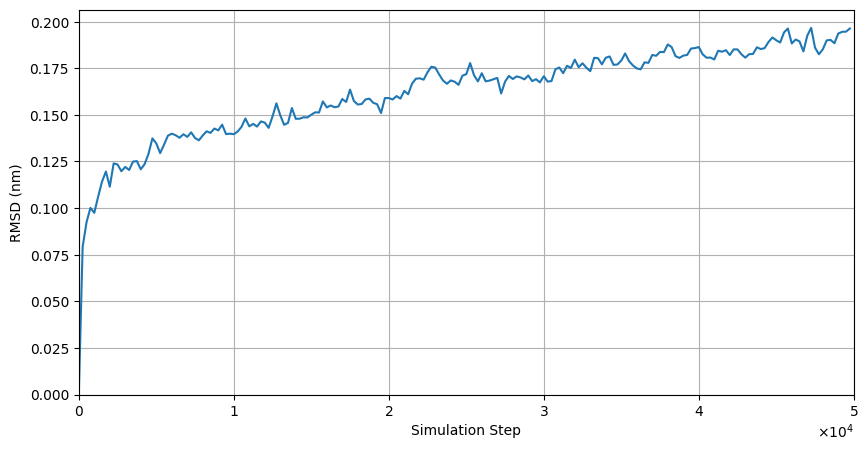

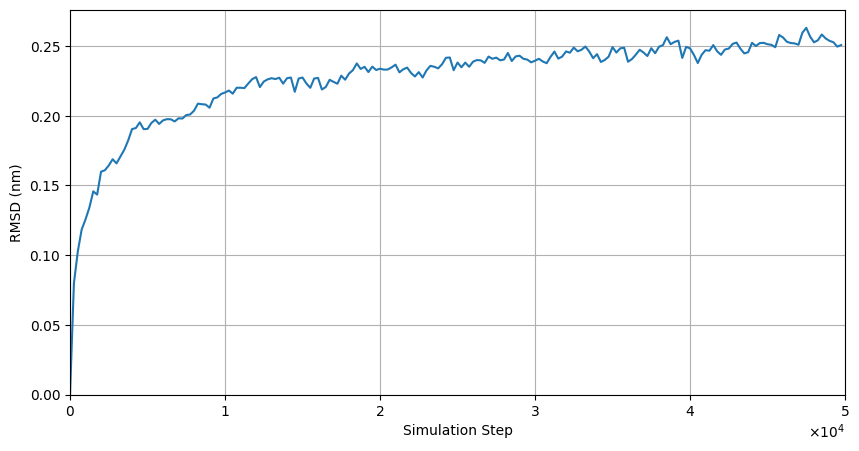

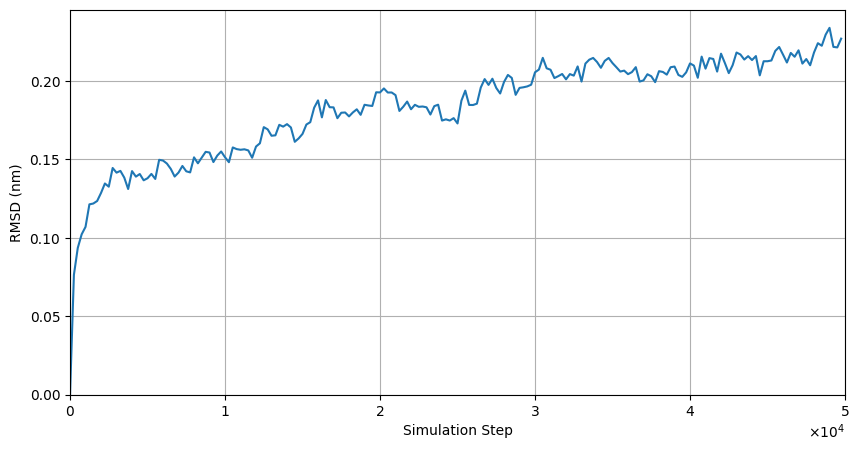

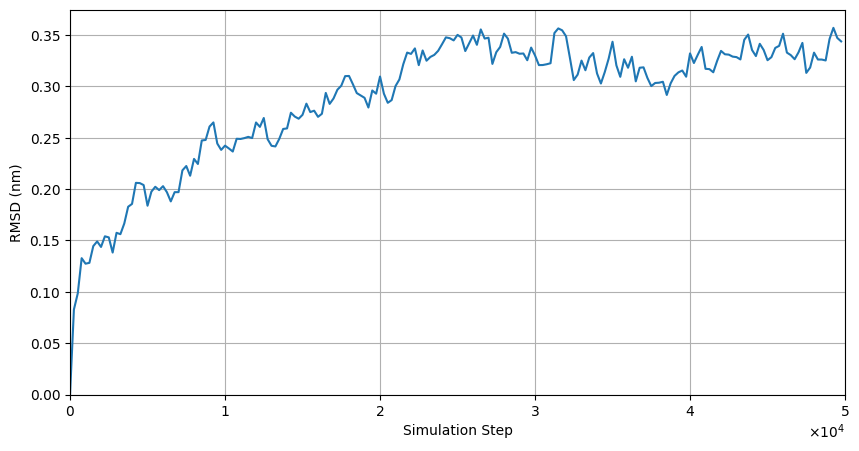

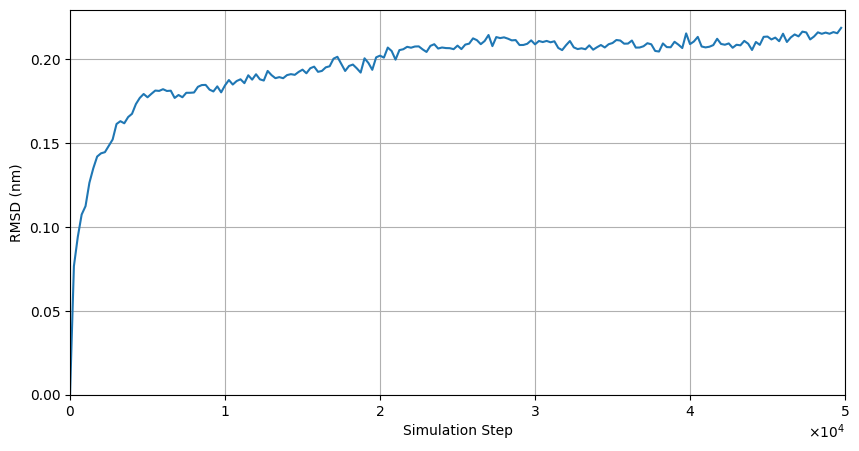

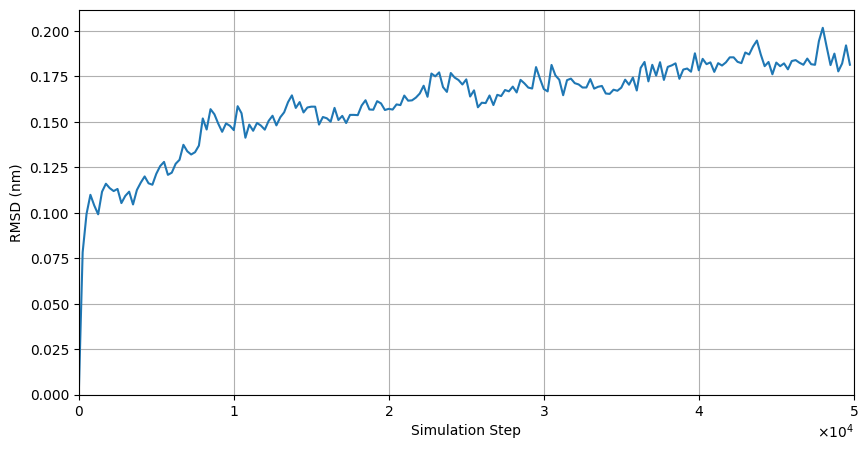

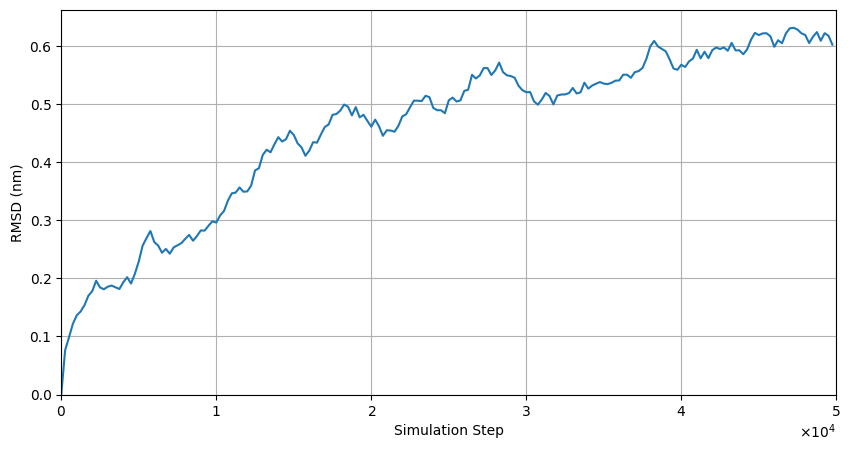

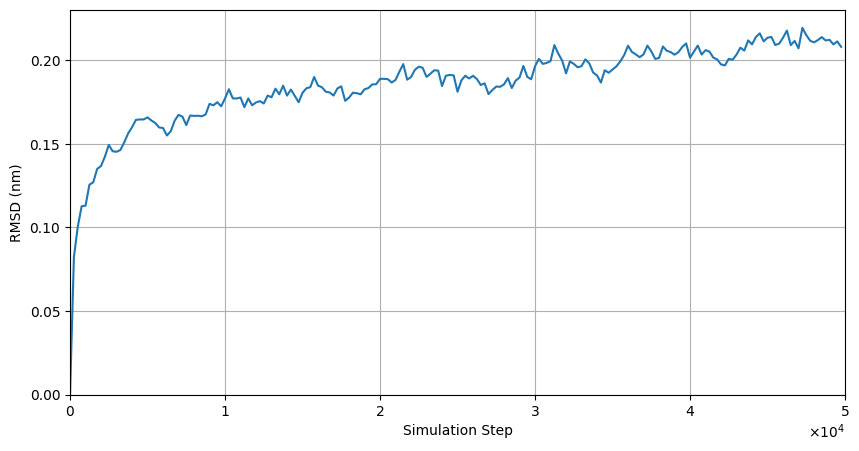

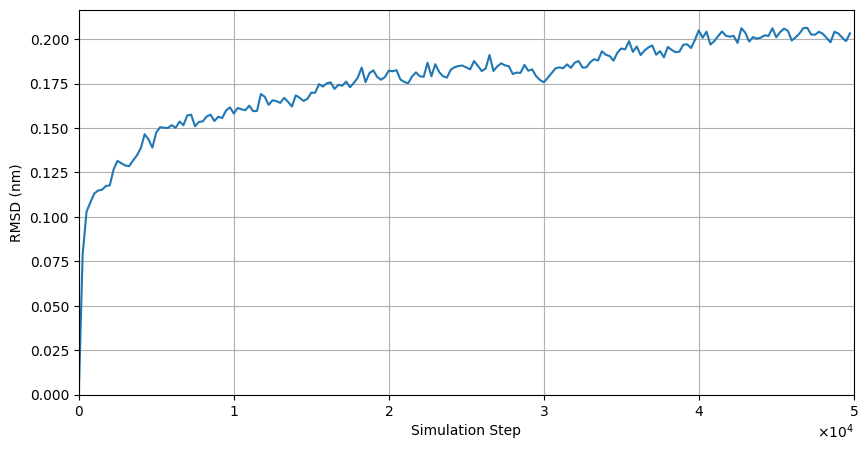

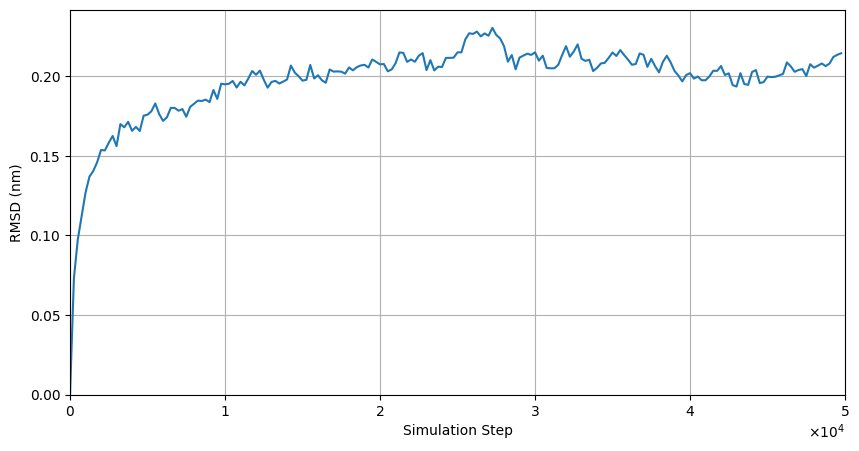

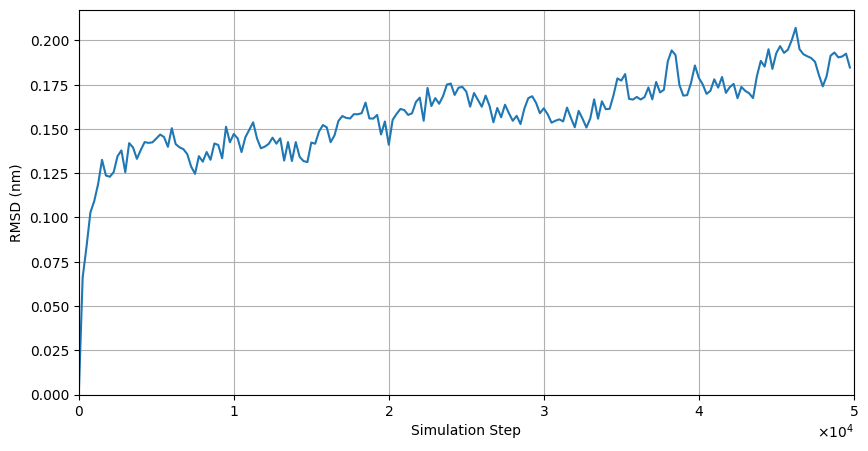

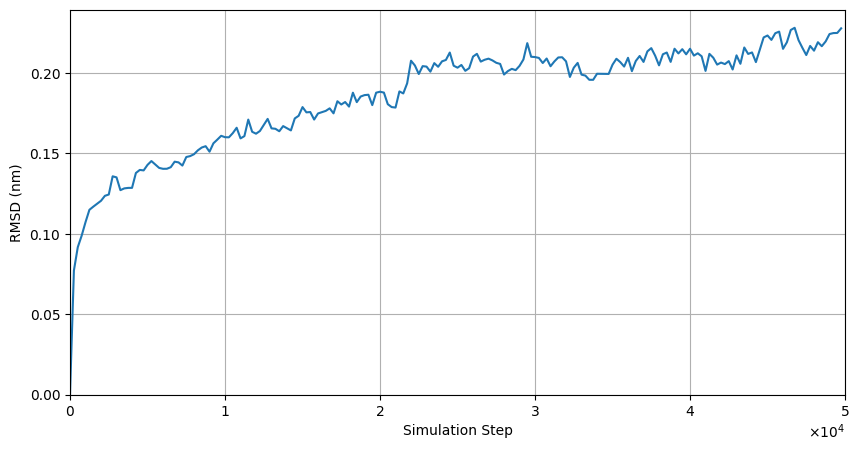

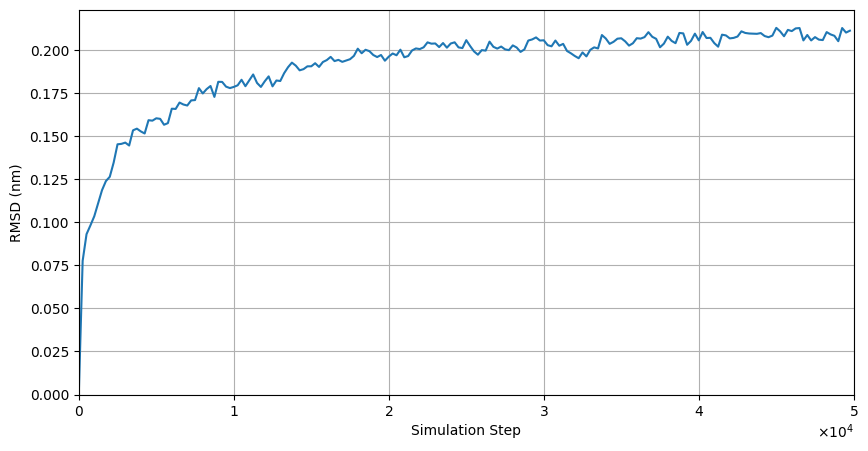

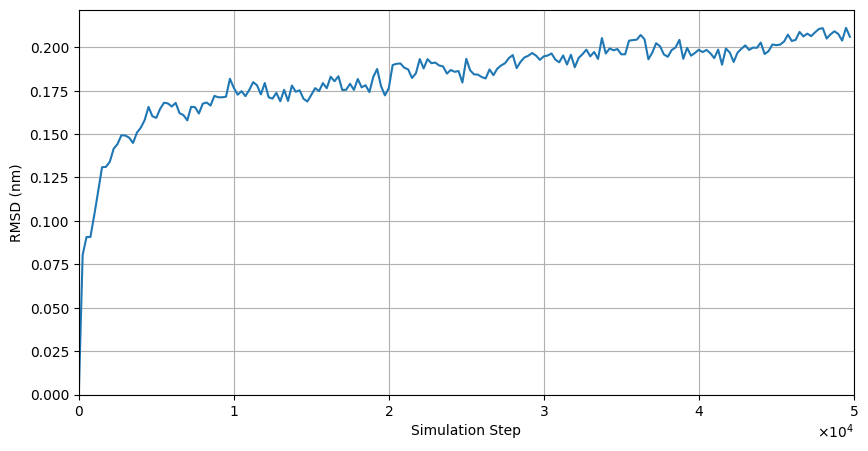

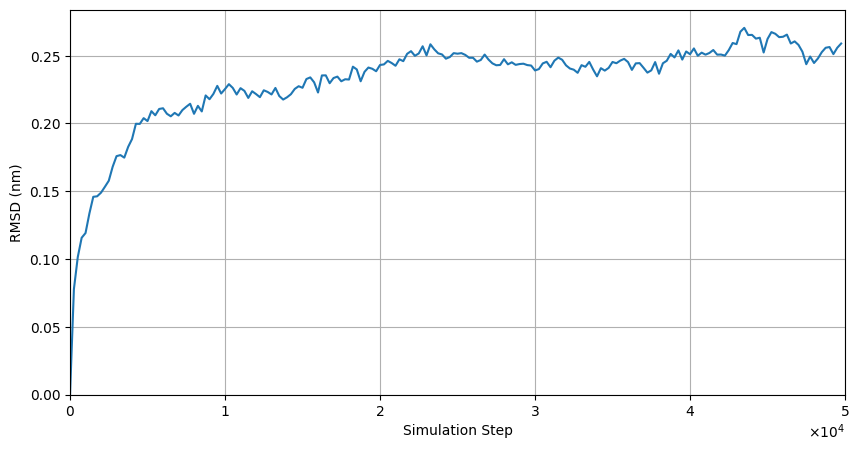

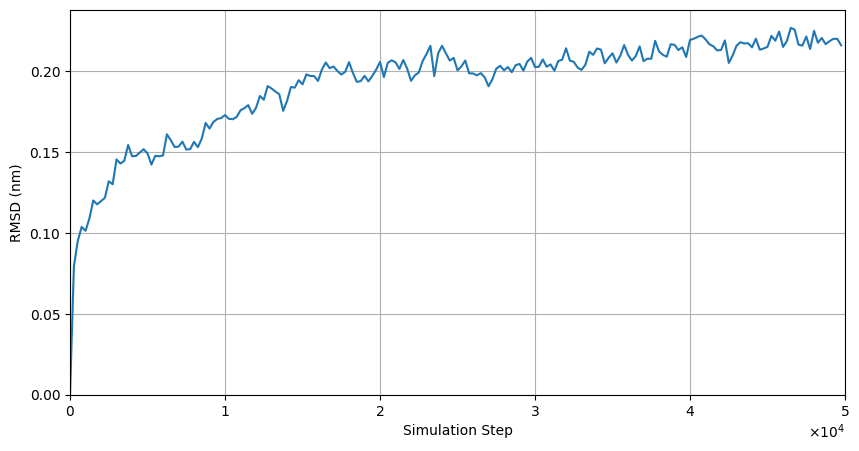

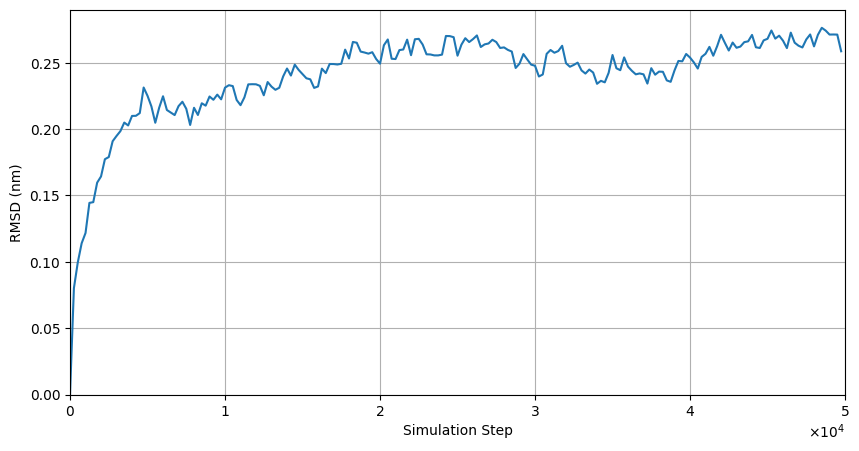

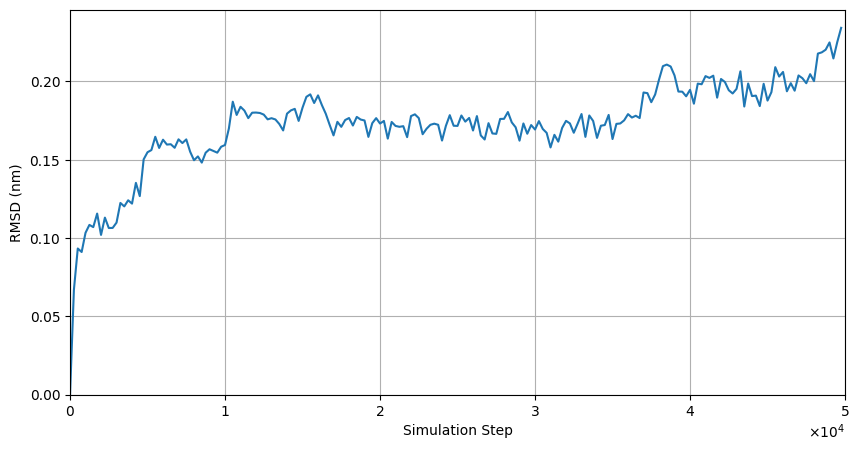

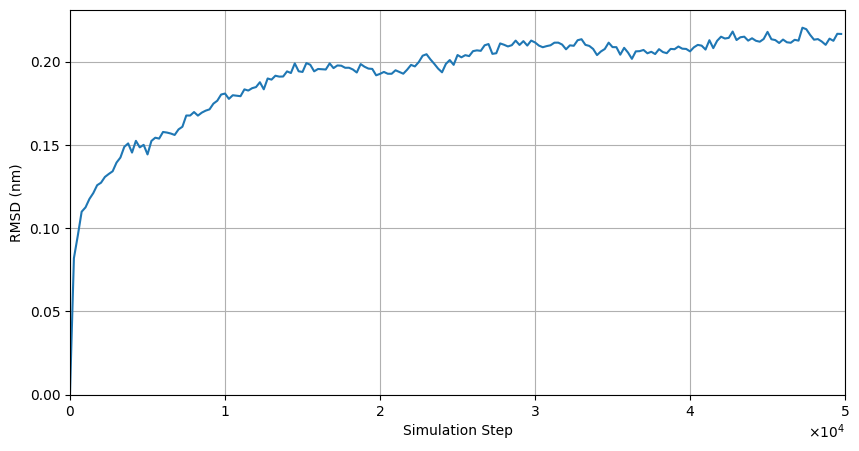

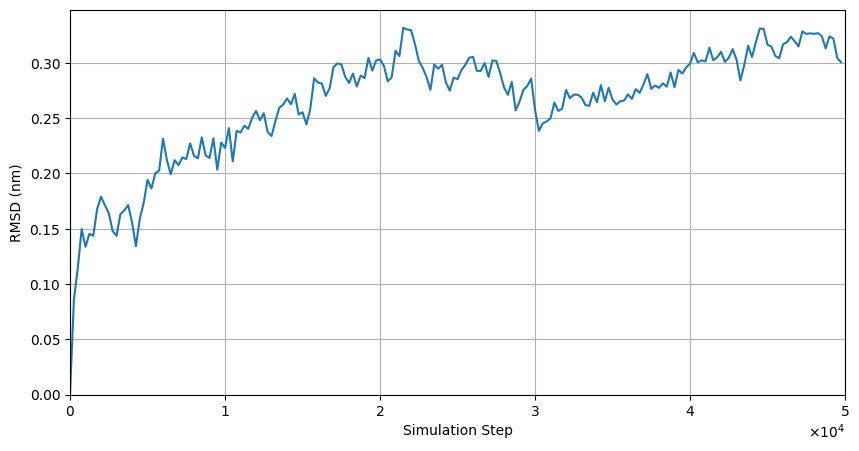

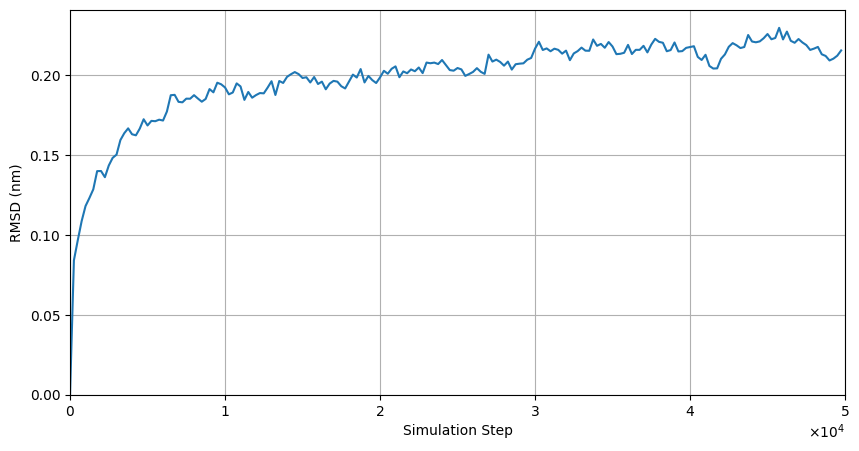

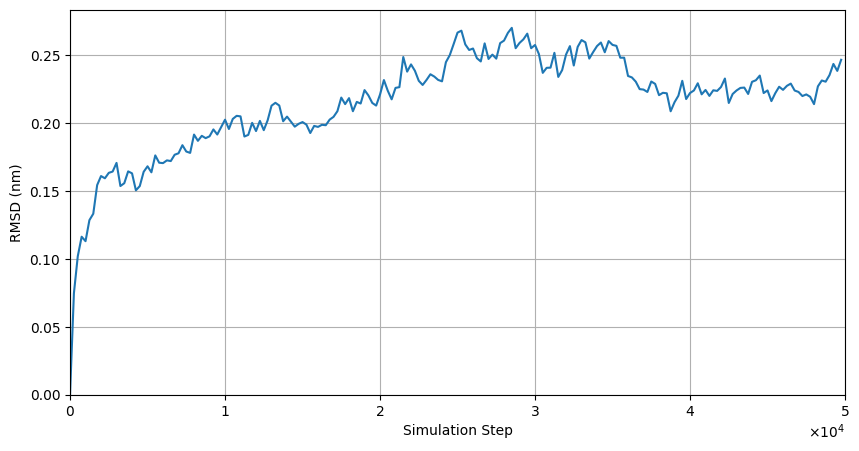

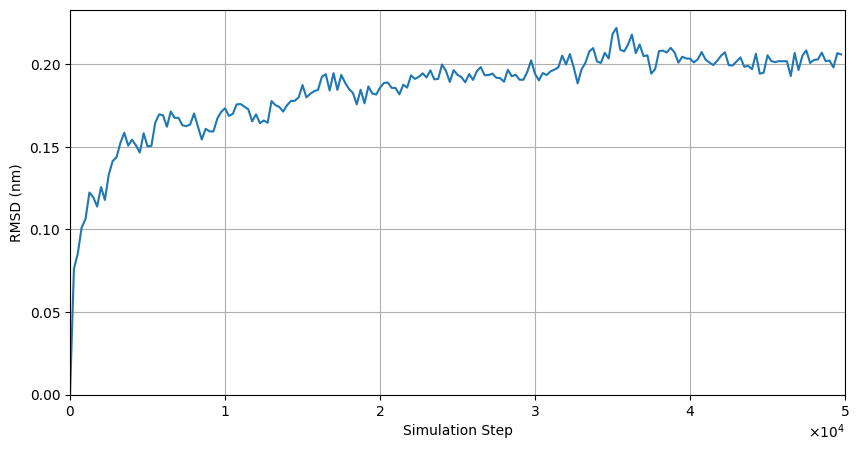

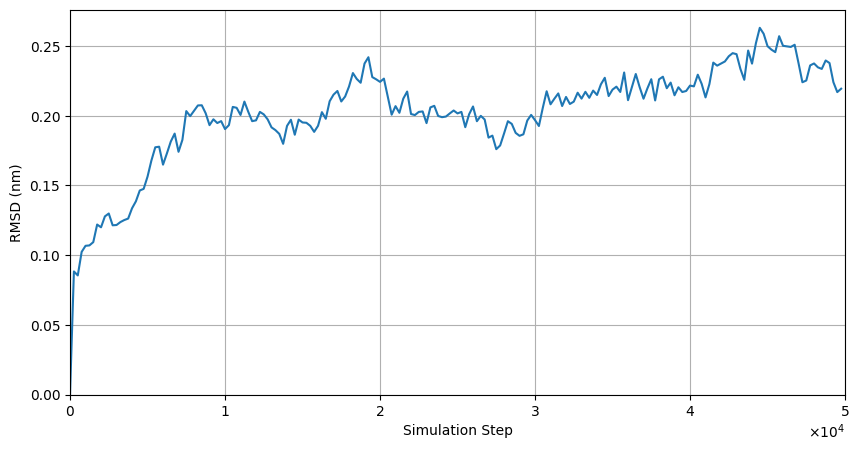

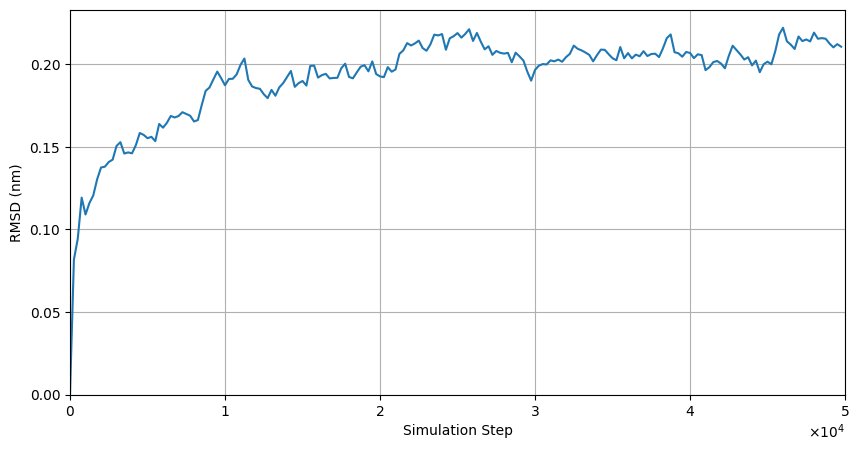

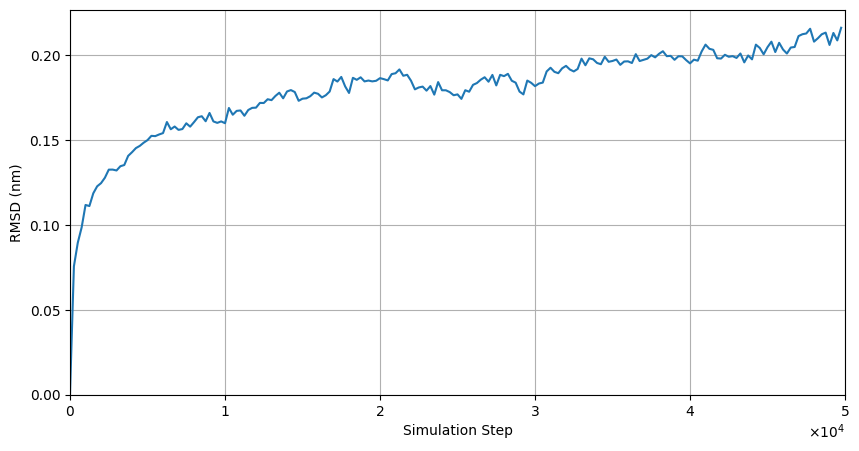

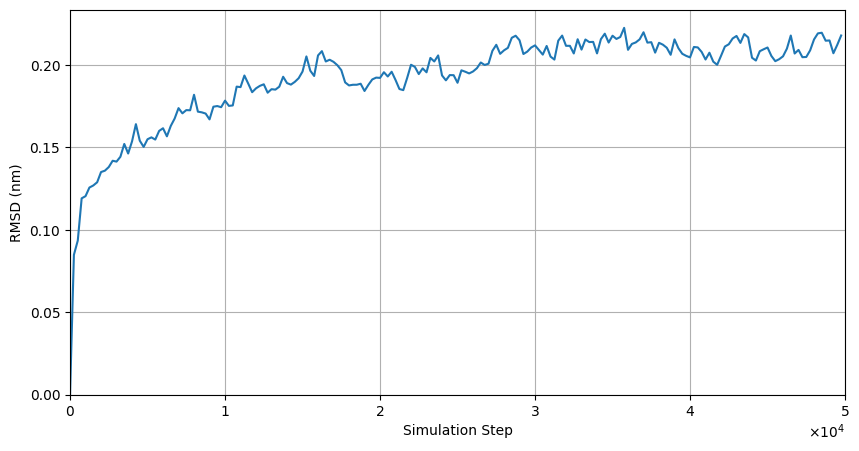

In [ ]:
run_openmm('Ca',4)